# $NicheVI-workflow$

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%reload_ext autoreload

In [3]:
import anndata as ad
import numpy as np
import pandas as pd

from rich import print
import os

import scvi

import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc

from scib_metrics.benchmark import Benchmarker, BatchCorrection
from scvi.strip_metrics import SpatialAnalysis

In [4]:
scvi.settings.seed = 34

Global seed set to 34


In [5]:
# !ls /home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH

!ls /home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/

adata_MERFISH_24w.h5ad
adata_scvi_merfish4w.h5ad
BrainAging_MERFISH_4weeks_major_ct.h5ad
BrainAgingSpatialAtlas_MERFISH_24weeks.h5ad
BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad
BrainAgingSpatialAtlas_MERFISH.h5ad
BrainAgingSpatialAtlas_MERFISH.ipynb


In [6]:
plots = True

In [7]:
data_dirs = {
    "VIZGEN_Liver": [
        "/home/nathanlevy/Data/Liver_VIZGEN/",
        "liver-joint-scvi3-annotated.h5ad",
    ],
    "MERFISH_Brain": [
        # "/home/labs/nyosef/Collaboration/SpatialDatasets/merfish/BrainAgingSpatialAtlas_MERFISH/",
        "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/",
        # "adata_scvi_merfish4w.h5ad",
        # "BrainAgingSpatialAtlas_MERFISH_4weeks.h5ad",
        "BrainAging_MERFISH_4weeks_major_ct.h5ad",
    ],
    "NANOSTRING_Lung": [
        "/home/nathanlevy/Data/",
        "nanostring_bis_finished_hotspot_densities.h5ad",
    ],
}

In [8]:
# data_dir = "/home/nathanlevy/Data/BrainAgingSpatialAtlas_MERFISH/"
# data_file = "adata_scvi_merfish4w.h5ad"

data_dir, data_file = data_dirs["MERFISH_Brain"]

data_file_name = os.path.splitext(data_file)[0]
print(data_file_name)

BrainAging_MERFISH_4weeks_major_ct

In [9]:
path_to_save = os.path.join("checkpoints", data_file_name)
os.makedirs(path_to_save, exist_ok=True)

In [10]:
adata = ad.read_h5ad(data_dir + data_file)
print(adata)

AnnData object with n_obs × n_vars = 123005 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'centroids', 'spatial'
    layers: 'counts'

In [11]:
adata.obs["cell_type"].value_counts()

cell_type
neuron                            34554
medium spiny neuron               25668
oligodendrocyte                   13113
astrocyte                         12831
endothelial cell                  11376
inhibitory interneuron            10330
microglial cell                    6317
oligodendrocyte precursor cell     4235
pericyte                           3443
vascular leptomeningeal cell       1138
Name: count, dtype: int64

In [12]:
# adata.X = adata.layers["counts"]  # putting in the X matrtix the raw counts
# adata.obs["cell_type"] = adata.obs['annotation']

# # subset the data to only include the samples we want to analyze: Liver1Slice1 and Liver2Slice1
# adata = adata[
#     adata.obs["sample"].isin(["Liver1Slice1", "Liver2Slice1"])
# ].copy()

# subset the anndata to remove macrophage, cell and T cell:
# adata = adata[~adata.obs["cell_type"].isin(["macrophage", "T cell", "cell"])].copy()

adata.obsm["centroids"] = adata.obs[["center_x", "center_y"]].values

In [13]:
# save the adata
# adata.write_h5ad(data_dir + "/BrainAging_MERFISH_4weeks_major_ct.h5ad")

In [14]:
print(adata)

AnnData object with n_obs × n_vars = 123005 × 374
    obs: 'fov', 'center_x', 'center_y', 'min_x', 'max_x', 'min_y', 'max_y', 'age', 'clust_annot', 'slice', 
'organism_ontology_term_id', 'sex_ontology_term_id', 'suspension_type', 'cell_type_ontology_term_id', 
'assay_ontology_term_id', 'tissue_ontology_term_id', 'disease_ontology_term_id', 
'self_reported_ethnicity_ontology_term_id', 'development_stage_ontology_term_id', 'donor_id', 'is_primary_data', 
'cell_type_annot', 'cell_type', 'assay', 'disease', 'organism', 'sex', 'tissue', 'self_reported_ethnicity', 
'development_stage', 'donor_slice'
    var: 'feature_is_filtered', 'feature_name', 'feature_reference', 'feature_biotype'
    uns: 'batch_condition', 'cell_type_colors', 'schema_version', 'title'
    obsm: 'X_pca', 'X_spatial', 'X_umap', 'centroids', 'spatial'
    layers: 'counts'

In [15]:
# for sample in adata.obs.donor_slice.unique().tolist()[:1]:
#     sc.pl.spatial(
#         adata[adata.obs.donor_slice == sample],
#         spot_size=40,
#         color=["cell_type", "donor_id"],
#         ncols=2,
#         frameon=False,
#         title=sample,
#     )

## First train (linear)scVI

In [16]:
N_LAYERS = 1
N_LATENT = 10
LIKELIHOOD = "poisson"
BATCH_KEY = "donor_id"
######################
N_EPOCHS_LVAE = 130
N_EPOCHS_SCVI = 200
######################
WEIGHT_DECAY = 1e-3
KL_WARMUP = None
REC_WARMUP = None
MIN_REC_WEIGHT = 1.0
MAX_REC_WEIGHT = 1.0

In [17]:
lvae_is_trained = True
save_lvae = True

if lvae_is_trained:
    vae = scvi.model.LinearSCVI.load(
        dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS_LVAE) + ".pt", adata=adata
    )

if lvae_is_trained == False:
    scvi.model.LinearSCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    vae = scvi.model.LinearSCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    vae.train(
        max_epochs=N_EPOCHS_LVAE,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=KL_WARMUP, weight_decay=WEIGHT_DECAY),
        early_stopping=True,
    )

    if save_lvae:
        vae.save(
            dir_path=path_to_save + "/lvae_E" + str(N_EPOCHS_LVAE) + ".pt",
            save_anndata=False,
        )

INFO     File checkpoints/BrainAging_MERFISH_4weeks_major_ct/lvae_E130.pt/model.pt already downloaded              


In [18]:
vae.summary_stats  #

n_batch: 4
n_cells: 123005
n_labels: 1
n_vars: 374

In [19]:
# if plots:
#     sc.pp.neighbors(adata, use_rep="qz1_m")
#     sc.tl.umap(adata, min_dist=0.3)

#     if "niche_type" in adata.obs.columns:
#         sc.pl.umap(
#             adata,
#             color=["cell_type", "niche_type"],
#             ncols=3,
#             frameon=False,
#             palette="tab20",
#         )

#     else:
#         sc.pl.umap(
#             adata,
#             color=["cell_type", "donor_id"],
#             ncols=2,
#             frameon=False,
#             palette="tab20",
#         )

In [20]:
vae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

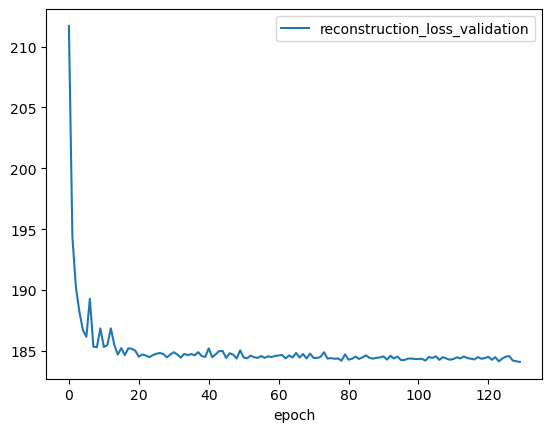

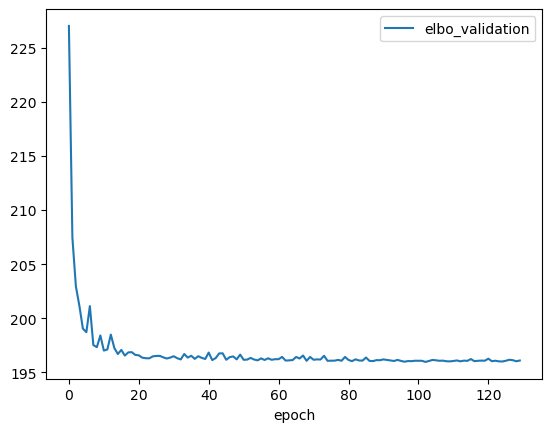

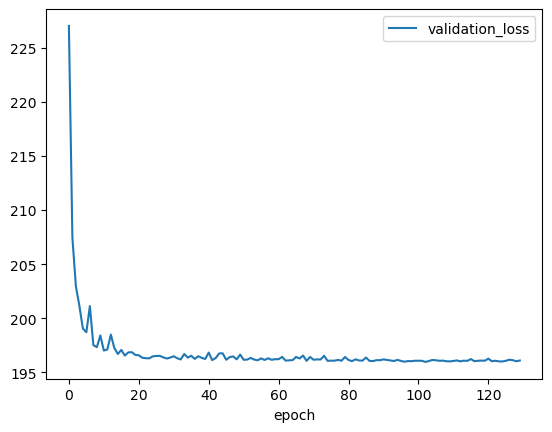

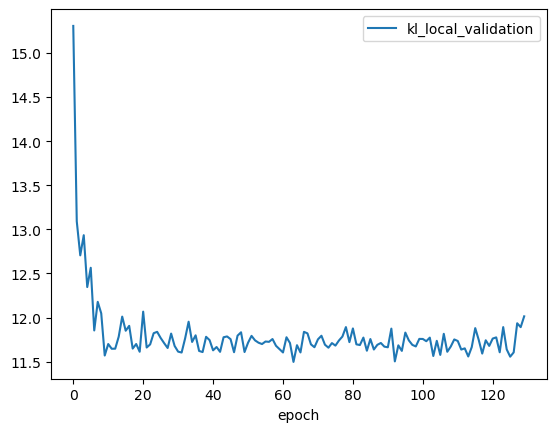

In [21]:
vae.history["reconstruction_loss_validation"].plot()
vae.history["elbo_validation"].plot()
vae.history["validation_loss"].plot()
vae.history["kl_local_validation"].plot()

In [22]:
is_trained = True
save_scvi = True

if is_trained == False:
    scvi.model.SCVI.setup_anndata(
        adata,
        layer="counts",
        batch_key=BATCH_KEY,
    )

    scvivae = scvi.model.SCVI(
        adata,
        gene_likelihood=LIKELIHOOD,
        n_layers=N_LAYERS,
        n_latent=N_LATENT,
    )

    scvivae.train(
        max_epochs=N_EPOCHS_SCVI,
        train_size=0.8,
        validation_size=0.2,
        plan_kwargs=dict(n_epochs_kl_warmup=KL_WARMUP, weight_decay=WEIGHT_DECAY),
        # trainer_kwargs=dict(check_val_every_n_epoch=1),
        early_stopping=True,
    )

    if save_scvi:
        scvivae.save(
            dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS_SCVI) + ".pt",
            save_anndata=False,
        )

if is_trained:
    scvivae = scvi.model.SCVI.load(
        dir_path=path_to_save + "/scvivae_E" + str(N_EPOCHS_SCVI) + ".pt", adata=adata
    )

adata.obsm["X_scVI"] = scvivae.get_latent_representation()

INFO     File checkpoints/BrainAging_MERFISH_4weeks_major_ct/scvivae_E200.pt/model.pt already downloaded           


**Retrieve the observations/ z1_latent for nicheVI**:

In [23]:
adata.obsm["qz1_m"], adata.obsm["qz1_var"] = scvivae.get_latent_representation(
    return_dist=True
)

In [24]:
scvivae.history.keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train'])

<Axes: xlabel='epoch'>

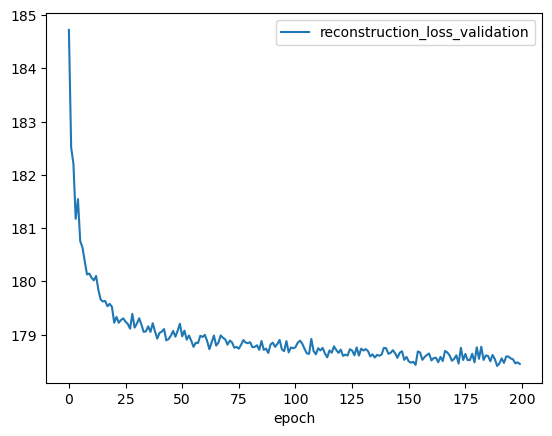

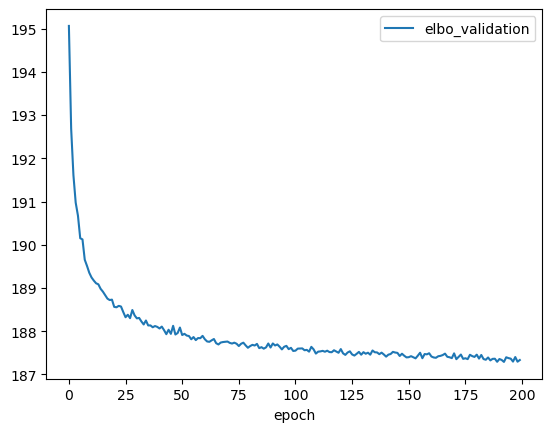

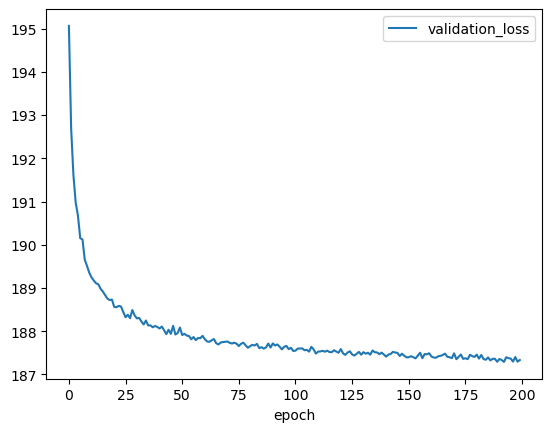

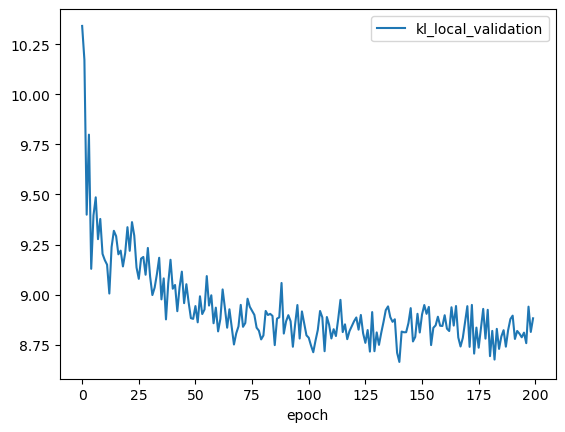

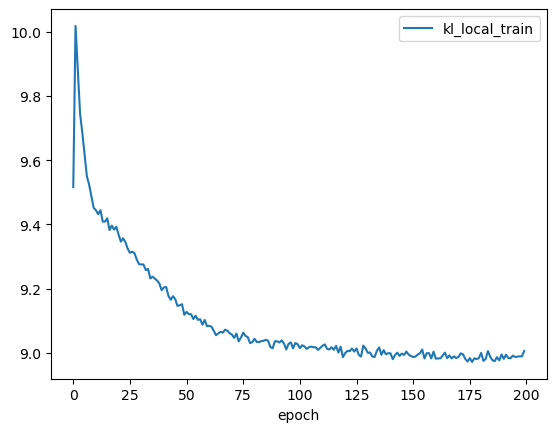

In [25]:
scvivae.history["reconstruction_loss_validation"].plot()
scvivae.history["elbo_validation"].plot()
scvivae.history["validation_loss"].plot()
scvivae.history["kl_local_validation"].plot()
scvivae.history["kl_local_train"].plot()

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nathanlevy/mambaforge/envs/phenospace_23

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


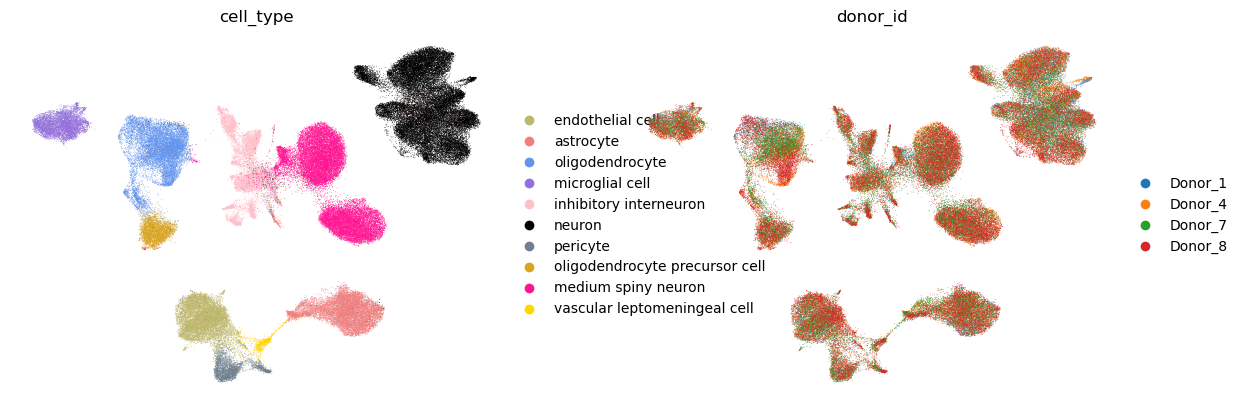

In [26]:
if plots:
    sc.pp.neighbors(adata, use_rep="X_scVI")
    sc.tl.umap(adata, min_dist=0.3)

    if "niche_type" in adata.obs.columns:
        sc.pl.umap(
            adata,
            color=["cell_type", "niche_type"],
            ncols=3,
            frameon=False,
        )

    else:
        sc.pl.umap(
            adata,
            color=["cell_type", "donor_id"],
            ncols=2,
            frameon=False,
        )

In [27]:
# sc.pl.umap(
#     adata,
#     color=["niche_cell_type"],
#     frameon=False,
# )

## Then train $nicheVI$

Parameters

In [111]:
K_NN = 20
N_LAYERS_NICHE = 1
N_LAYERS_COMPO = 1
N_HIDDEN = 128
N_HIDDEN_COMPO = 64
N_HIDDEN_NICHE = 128
SAMPLE_KEY = "donor_slice"
OBS_OR_LATENT = "observed"
N_LATENT_NICHEVI = 10
######################
N_EPOCHS_NICHEVI = 150
SOFTMAX_TEMPERATURE = 1.0
REDUCE_LR_ON_PLATEAU = True
# +batch norm/layer norm

In [71]:
adata.obsm["qz1_m"] = adata.layers["counts"]
adata.obsm["qz1_var"] = adata.layers["counts"]

In [72]:
# preprocessing function to populate adata.obsm with the keys 'neighborhood_composition',
# 'qz1_m', 'qz1_var', 'niche_indexes', 'niche_distances', 'qz1_m_niche_knn', 'qz1_var_niche_knn', 'qz1_m_niche_ct',
# 'qz1_var_niche_ct'

scvi.model.nicheSCVI.preprocessing_anndata(
    adata,
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    niche_type_key="niche_type",
    niche_treshold=0.2,
    cell_type_for_niches=[
        "neuron",
        "oligodendrocyte",
        "astrocyte",
        "medium spiny neuron",
    ],
    label_key="cell_type",
    sample_key=SAMPLE_KEY,
    cell_coordinates_key="centroids",
    k_nn=K_NN,
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    # latent_mean_niche_keys=None,
    latent_mean_niche_keys=["qz1_m_niche_ct"],
    latent_var_niche_keys=["qz1_var_niche_ct"],
    latent_mean_knn_key="latent_mean_knn",
    zero_prior=True,
)

Saved niche_indexes and niche_distances in adata.obsm

Saved niche_composition in adata.obsm

/home/nathanlevy/spatial-scvi/scvi/model/_nichescvi.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  composition_subet["niche_assignment"] = composition_subet.idxmax(axis=1)


Saved qz1_m_niche_ct and qz1_var_niche_ct in adata.obsm

In [79]:
adata.obsm["qz1_m_niche_ct"] = np.ceil(adata.obsm["qz1_m_niche_ct"])

In [80]:
adata.obs["niche_cell_type"] = (
    adata.obs["niche_type"].astype(str) + "_" + adata.obs["cell_type"].astype(str)
)

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/anndata/_core/anndata.py:1222: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


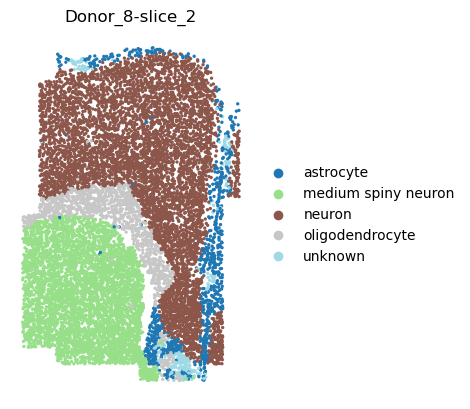

In [31]:
# for sample in adata.obs.donor_slice.unique().tolist()[:3]:
for sample in ["Donor_8-slice_2"]:
    sc.pl.spatial(
        adata=adata[adata.obs["donor_slice"] == sample],
        spot_size=40,
        color=["niche_type"],
        ncols=1,
        frameon=False,
        title=sample,
        palette="tab20",
    )

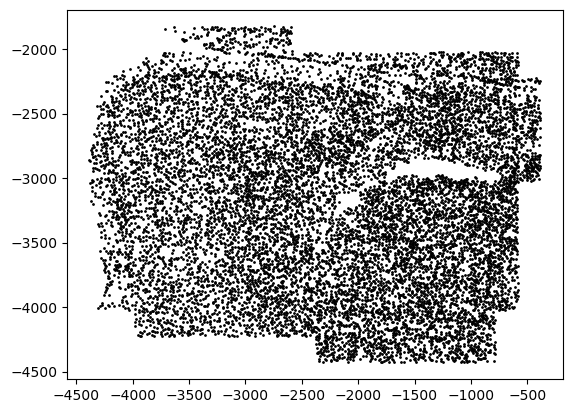

In [172]:
pl = adata.obsm['centroids'][adata.obs.donor_slice == 'Donor_8-slice_2']
plt.scatter(pl[:, 1], pl[:, 0], s=1, c='k')

In [32]:
print(adata.obsm.keys())

KeysView(AxisArrays with keys: X_pca, X_spatial, X_umap, centroids, spatial, X_scVI, qz1_m, qz1_var, niche_indexes,
niche_distances, neighborhood_composition, latent_mean_knn, qz1_m_niche_ct, qz1_var_niche_ct)

In [81]:
scvi.model.nicheSCVI.setup_anndata(
    adata,
    layer="counts",
    batch_key=BATCH_KEY,
    labels_key="cell_type",
    niche_composition_key="neighborhood_composition",
    niche_indexes_key="niche_indexes",
    niche_distances_key="niche_distances",
    latent_mean_key="qz1_m",
    latent_var_key="qz1_var",
    latent_mean_ct_key="qz1_m_niche_ct",
    latent_var_ct_key="qz1_var_niche_ct",
)

INFO     Using column names from columns of adata.obsm['neighborhood_composition']                                 
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        
INFO     Generating sequential column names                                                                        


In [82]:
adata.obsm["qz1_m_niche_ct"].shape

(123005, 10, 374)

In [114]:
niche_setup = {
    "Poisson_r1_kl1_c1_n1": {
        "cell_rec_weight": 1,
        "latent_kl_weight": 1.0,
        "niche_compo_weight": 1,
        "niche_rec_weight": 1,
        "n_latent": N_LATENT_NICHEVI,
        "n_layers_niche": N_LAYERS_NICHE,
        "n_layers_compo": N_LAYERS_COMPO,
        "n_hidden_niche": N_HIDDEN_NICHE,
        "n_hidden_compo": N_HIDDEN_COMPO,
        "niche_status": "observed",
    },
    # "so_r1_kl1_c1_n1_z20": {
    #     "cell_rec_weight": 1,
    #     "latent_kl_weight": 1,
    #     "niche_compo_weight": 1,
    #     "niche_rec_weight": 1,
    #     "n_latent": 2*N_LATENT,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "so_r1_kl1_c20_n20": {
    #     "cell_rec_weight": 1,
    #     "latent_kl_weight": 1,
    #     "niche_compo_weight": 20,
    #     "niche_rec_weight": 20,
    #     "n_latent": N_LATENT,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "so_r1_kl1_c50_n50": {
    #     "cell_rec_weight": 1,
    #     "latent_kl_weight": 1,
    #     "niche_compo_weight": 50,
    #     "niche_rec_weight": 50,
    #     "n_latent": N_LATENT,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "so_r1_kl1_c10_n10": {
    #     "cell_rec_weight": 1,
    #     "latent_kl_weight": 1,
    #     "niche_compo_weight": 10,
    #     "niche_rec_weight": 10,
    #     "n_latent": N_LATENT,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "so_r01_kl1_c10_n0": {
    #     "cell_rec_weight": 0.1,
    #     "latent_kl_weight": 1.0,
    #     "niche_compo_weight": 10,
    #     "niche_rec_weight": 0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "so_r1_kl1_c10_n0": {
    #     "cell_rec_weight": 1,
    #     "latent_kl_weight": 1.0,
    #     "niche_compo_weight": 10,
    #     "niche_rec_weight": 0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "o_r0_kl0_c0_n1": {
    #     "cell_rec_weight": 0,
    #     "niche_rec_weight": 1.0,
    #     "niche_compo_weight": 0.0,
    #     "latent_kl_weight": 0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    #     "niche_status": "observed",
    # },
    # "r0_kl01_c10_n0": {
    #     "cell_rec_weight": 0.0,
    #     "niche_rec_weight": 0.0,
    #     "niche_compo_weight": 10,
    #     "latent_kl_weight": 0.1,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    # },
    # "r01_kl1_c0_n10": {
    #     "cell_rec_weight": 0.1,
    #     "niche_rec_weight": 10,
    #     "niche_compo_weight": 0,
    #     "latent_kl_weight": 1,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    # },
    # "r01_kl1_c10_n0": {
    #     "cell_rec_weight": 0.1,
    #     "niche_rec_weight": 0,
    #     "niche_compo_weight": 10,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    # },
    # "r1_kl1_c1_n1": {
    #     "cell_rec_weight": 1,
    #     "niche_rec_weight": 1,
    #     "niche_compo_weight": 1,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    # },
    # "r01_kl1_c1_n10": {
    #     "cell_rec_weight": 0.1,
    #     "niche_rec_weight": 10,
    #     "niche_compo_weight": 1,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN,
    #     "n_hidden_compo": N_HIDDEN,
    # # },
    # "s_r1_kl1_c10_n10": {
    #     "cell_rec_weight": 1,
    #     "niche_rec_weight": 10,
    #     "niche_compo_weight": 1,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN_NICHE,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    # },
    # "so_r1_kl1_c10_n10": {
    #     "cell_rec_weight": 1,
    #     "niche_rec_weight": 10,
    #     "niche_compo_weight": 10,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN_NICHE,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "observed",
    # },
    # "sl_r1_kl1_c0_n10": {
    #     "cell_rec_weight": 1,
    #     "niche_rec_weight": 10,
    #     "niche_compo_weight": 0,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN_NICHE,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": "latent",
    # },
    # "ss_r1_kl1_c10_n0": {
    #     "cell_rec_weight": 1,
    #     "niche_rec_weight": 0,
    #     "niche_compo_weight": 10,
    #     "latent_kl_weight": 1.0,
    #     "n_layers_niche": N_LAYERS_NICHE,
    #     "n_layers_compo": N_LAYERS_COMPO,
    #     "n_hidden_niche": N_HIDDEN_COMPO,
    #     "n_hidden_compo": N_HIDDEN_COMPO,
    #     "niche_status": OBS_OR_LATENT,
    # },
}

In [115]:
# niche_setup = {
# "o_r1_kl1_c10_n10": [],
# "o_r01_kl1_c10_n0": [],
# "o_r01_kl1_c0_n10": [],
# "so_r01_kl1_c10_n10": [],
# "o_r01_kl1_c10_n10": [],
# "sl_r1_kl1_c0_n10": [],
# "o_r0_kl0_c0_n1": [],
# "l_r0_kl0_c0_n1": [],
# "r1_kl1_c0_n0": [],
# 'so_r0_kl1_c10_n10': [],
# 'so_r1_kl0_c10_n0': [],
# 'so_r1_kl0_c0_n10': [],
# 'so_r1_kl0_c10_n10': [],
# 'so_r01_kl1_c10_n0': [],
# 'so_r1_kl1_c10_n0': [],
# "so_r1_kl1_c10_n10": [],
#     "so_r1_kl1_c1_n1": [],
#     "so_r1_kl1_c1_n1_z20": [],
#     "so_r1_kl1_c10_n10_z20": [],
#     # "so_r1_kl1_c20_n20": [],
# }
print(niche_setup.keys())

dict_keys(['Poisson_r1_kl1_c1_n1'])

In [116]:
niche_setup["Poisson_r1_kl1_c1_n1"]

{'cell_rec_weight': 1,
 'latent_kl_weight': 1.0,
 'niche_compo_weight': 1,
 'niche_rec_weight': 1,
 'n_latent': 10,
 'n_layers_niche': 1,
 'n_layers_compo': 1,
 'n_hidden_niche': 128,
 'n_hidden_compo': 64,
 'niche_status': 'observed'}

In [117]:
nichevae_is_trained = False
save_pt = False

In [118]:
history_setup = {}
latent_keys_for_benchmark = []
pred_keys_for_benchmark = []
activation_keys_for_benchmark = []

for setup in niche_setup.keys():
    print("[bold green]" + setup + "[/bold green]")
    setup_dict = niche_setup[setup]

    if nichevae_is_trained == False:
        nichevae = scvi.model.nicheSCVI(
            adata,
            cell_rec_weight=setup_dict["cell_rec_weight"],
            niche_rec_weight=setup_dict["niche_rec_weight"],
            niche_compo_weight=setup_dict["niche_compo_weight"],
            latent_kl_weight=setup_dict["latent_kl_weight"],
            niche_components="cell_type_unweighted",
            niche_combination=setup_dict["niche_status"],
            gene_likelihood=LIKELIHOOD,
            n_layers=N_LAYERS,
            n_output_niche=adata.obsm["qz1_m_niche_ct"].shape[-1],
            n_layers_niche=setup_dict["n_layers_niche"],
            n_layers_compo=setup_dict["n_layers_compo"],
            n_hidden_niche=setup_dict["n_hidden_niche"],
            n_hidden_compo=setup_dict["n_hidden_compo"],
            n_latent=setup_dict["n_latent"],
            compo_transform="none",
            compo_temperature=1.0,
            use_batch_norm="both",
            use_layer_norm="none",
        )

        nichevae.train(
            max_epochs=N_EPOCHS_NICHEVI,
            train_size=0.8,
            validation_size=0.2,
            plan_kwargs=dict(
                n_epochs_kl_warmup=KL_WARMUP,
                # n_epochs_kl_warmup=N_EPOCHS_NICHEVI,
                # min_kl_weight=MIN_REC_WEIGHT,
                # max_kl_weight=MAX_REC_WEIGHT,
                optimizer="AdamW",
                weight_decay=WEIGHT_DECAY,
                reduce_lr_on_plateau=REDUCE_LR_ON_PLATEAU,
            ),
            early_stopping=False,
            check_val_every_n_epoch=1,
            batch_size=128,
        )

        if save_pt:
            nichevae.save(
                dir_path=path_to_save
                + "/nichevae_"
                + setup
                + "_"
                + str(N_EPOCHS_NICHEVI)
                + ".pt",
                save_anndata=False,
            )

    if nichevae_is_trained:
        nichevae = scvi.model.nicheSCVI.load(
            dir_path=path_to_save
            + "/nichevae_"
            + setup
            + "_"
            + str(N_EPOCHS_NICHEVI)
            + ".pt",
            adata=adata,
        )

    history_setup[setup] = nichevae.history
    adata.obsm[setup + "_X_nicheVI"] = nichevae.get_latent_representation()
    latent_keys_for_benchmark.append(setup + "_X_nicheVI")
    adata.obsm[setup + "_pred_ct"] = nichevae.predict_neighborhood()
    pred_keys_for_benchmark.append(setup + "_pred_ct")
    adata.obsm[setup + "_niche_act"] = nichevae.predict_niche_activation()
    activation_keys_for_benchmark.append(setup + "_niche_act")

Poisson_r1_kl1_c1_n1

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3090') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/150:   0%|          | 0/150 [00:00<?, ?it/s]

Epoch 150/150: 100%|██████████| 150/150 [17:16<00:00,  7.14s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.14e+3]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 150/150: 100%|██████████| 150/150 [17:16<00:00,  6.91s/it, v_num=1, train_loss_step=1.14e+3, train_loss_epoch=1.14e+3]


In [119]:
nichevae.module.niche_decoder

NicheDecoder(
  (decoder): FCLayers(
    (fc_layers): Sequential(
      (Layer 0): Sequential(
        (0): Linear(in_features=14, out_features=128, bias=True)
        (1): BatchNorm1d(128, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        (2): None
        (3): ReLU()
        (4): None
      )
    )
  )
  (mean_decoder): Linear(in_features=128, out_features=3740, bias=True)
  (var_decoder): Linear(in_features=128, out_features=3740, bias=True)
)

In [120]:
# !ls checkpoints/BrainAgingSpatialAtlas_MERFISH_4weeks/
print(niche_setup.keys())

dict_keys(['Poisson_r1_kl1_c1_n1'])

In [90]:
key = setup
history_setup[key].keys()

dict_keys(['kl_weight', 'train_loss_step', 'validation_loss', 'elbo_validation', 'reconstruction_loss_validation', 'kl_local_validation', 'kl_global_validation', 'niche_compo_validation', 'niche_reconst_validation', 'train_loss_epoch', 'elbo_train', 'reconstruction_loss_train', 'kl_local_train', 'kl_global_train', 'niche_compo_train', 'niche_reconst_train'])

<Axes: xlabel='epoch'>

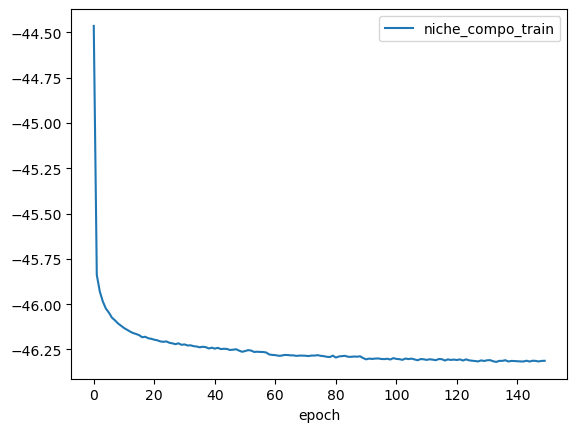

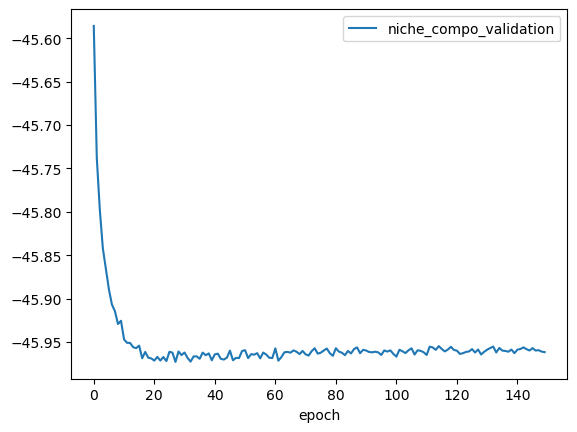

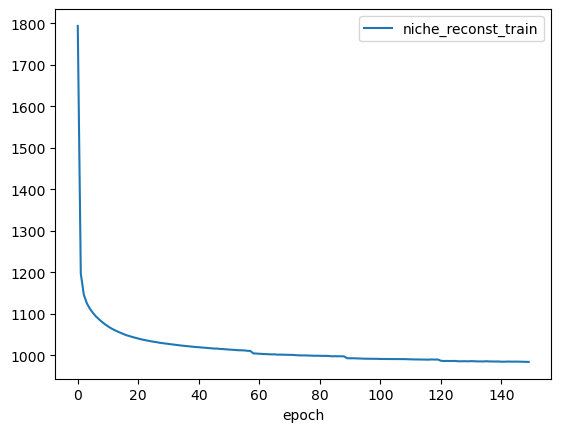

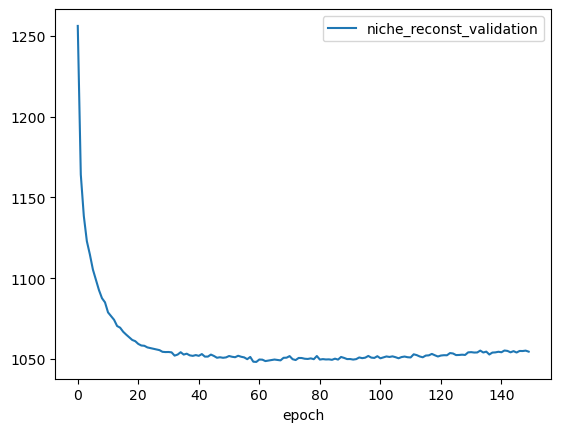

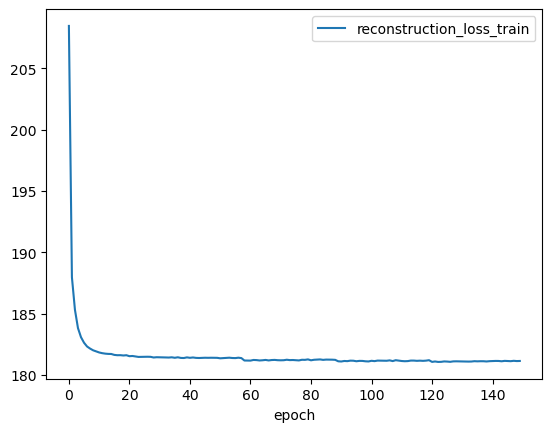

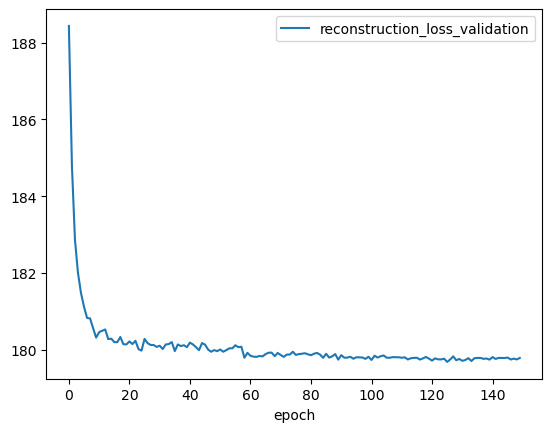

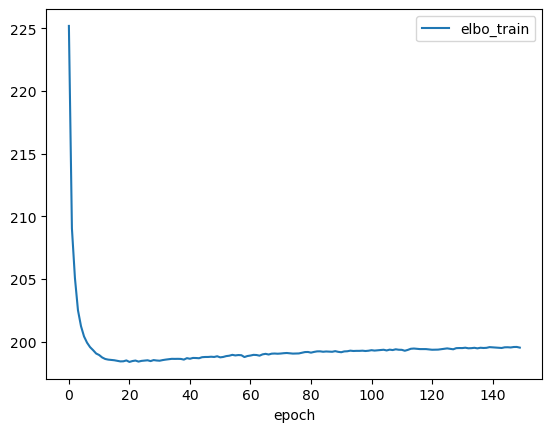

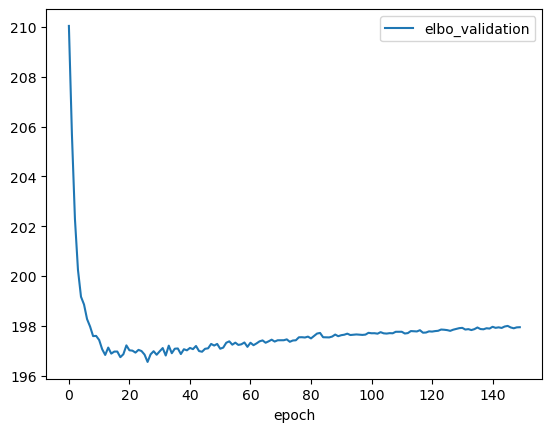

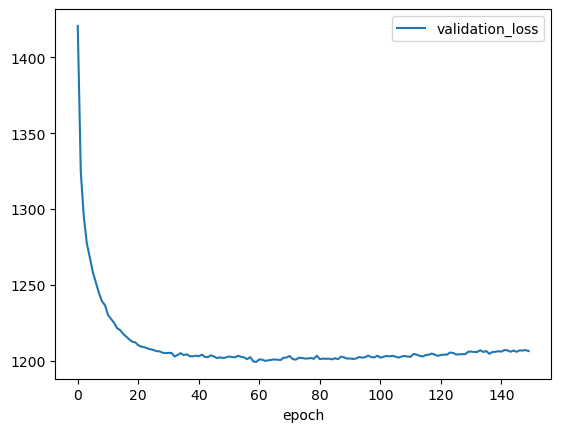

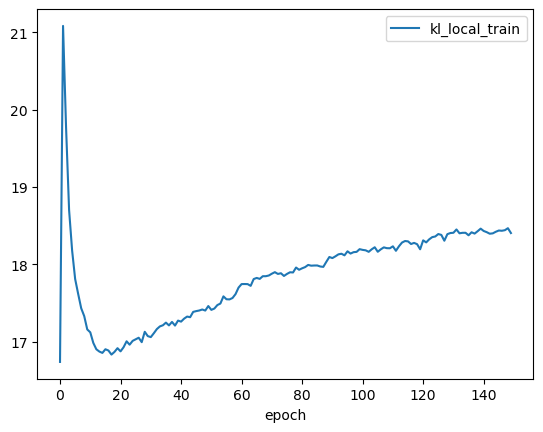

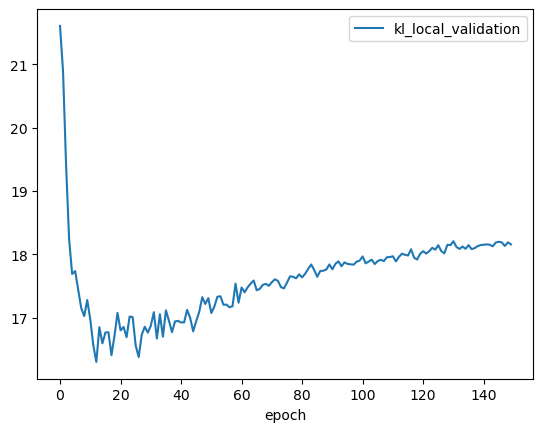

In [121]:
key = setup
# key = "so_r1_kl1_c1_n1"
# key = "so_r1_kl1_c10_n10"
# key = "r1_kl1_c0_n0"

history_setup[key]["niche_compo_train"].plot()
history_setup[key]["niche_compo_validation"].plot()
history_setup[key]["niche_reconst_train"].plot()
history_setup[key]["niche_reconst_validation"].plot()
history_setup[key]["reconstruction_loss_train"].plot()
history_setup[key]["reconstruction_loss_validation"].plot()
history_setup[key]["elbo_train"].plot()
history_setup[key]["elbo_validation"].plot()
history_setup[key]["validation_loss"].plot()
history_setup[key]["kl_local_train"].plot()
history_setup[key]["kl_local_validation"].plot()

In [42]:
# key = setup
# key = "L_r0_kl50_c50_t1"

# history_setup[key]["niche_CE_train"].plot()
# history_setup[key]["niche_CE_validation"].plot()
# history_setup[key]["niche_kl_train"].plot()
# history_setup[key]["niche_kl_validation"].plot()
# history_setup[key]["reconstruction_loss_train"].plot()
# history_setup[key]["reconstruction_loss_validation"].plot()
# history_setup[key]["elbo_validation"].plot()
# history_setup[key]["validation_loss"].plot()
# history_setup[key]["kl_local_validation"].plot()

In [43]:
# key = "mix_unif_kl10_compo10"

# history_setup[key]["reconstruction_loss_train"].plot()
# history_setup[key]["niche_kl_train"].plot()
# history_setup[key]["niche_CE_train"].plot()
# history_setup[key]["elbo_validation"].plot()

In [45]:
# history_setup['cell_type_setup_mixture']['kl_local_train'].plot()

In [46]:
adata.obsm["z2"] = adata.obsm[setup + "_X_nicheVI"][:, : nichevae.module.n_latent_niche]
adata.obsm["z1"] = adata.obsm[setup + "_X_nicheVI"][:, nichevae.module.n_latent_niche :]

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


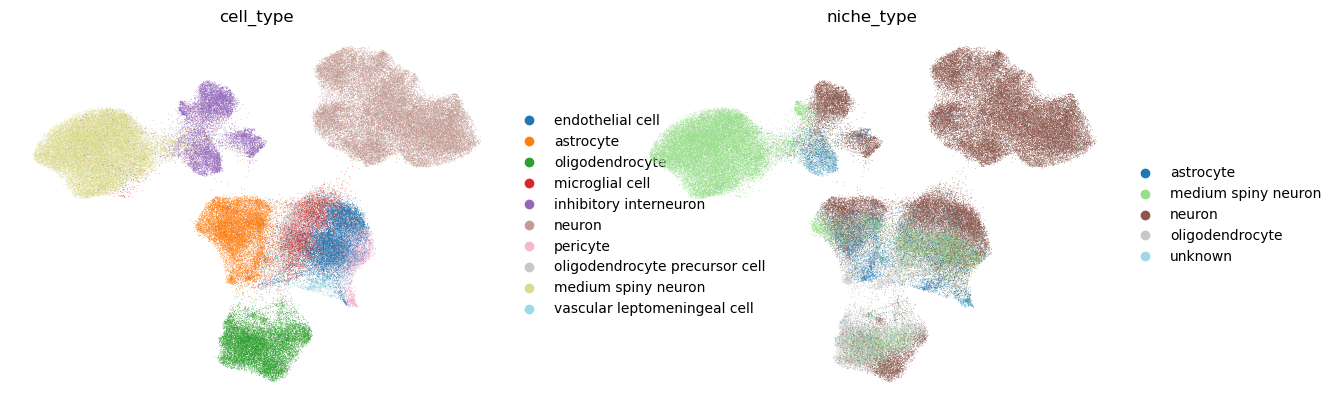

In [46]:
if plots:
    sc.pp.neighbors(adata, use_rep="z2")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "niche_type"],
        ncols=3,
        frameon=False,
        palette="tab20",
    )

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


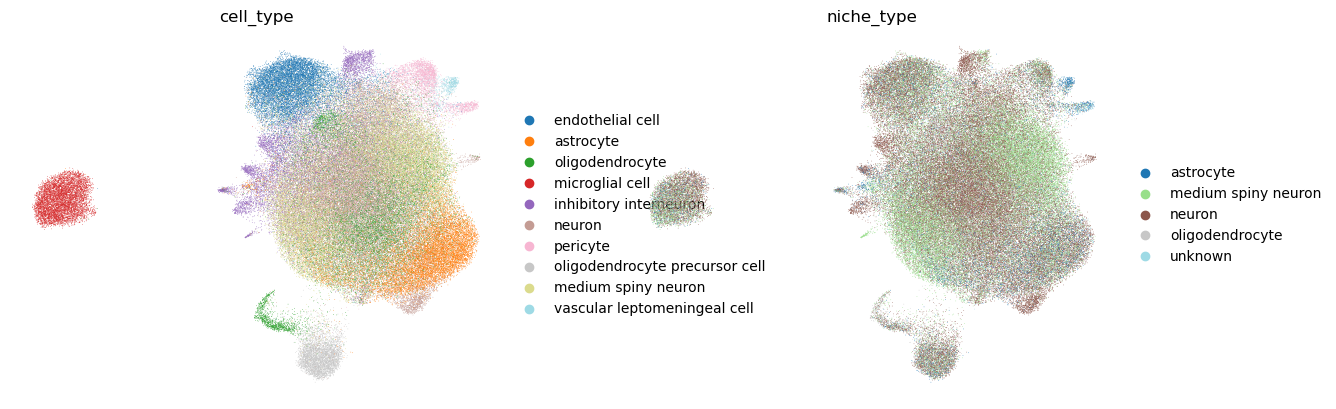

In [47]:
if plots:
    sc.pp.neighbors(adata, use_rep="z1")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "niche_type"],
        ncols=3,
        frameon=False,
        palette="tab20",
    )

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


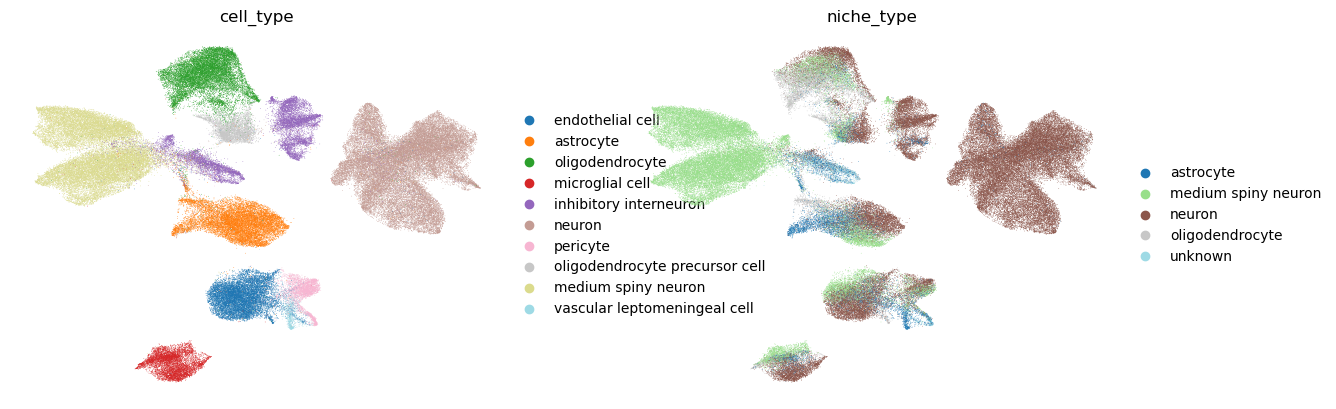

In [122]:
if plots:
    sc.pp.neighbors(adata, use_rep=setup + "_X_nicheVI")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "niche_type"],
        ncols=3,
        frameon=False,
        palette="tab20",
    )

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


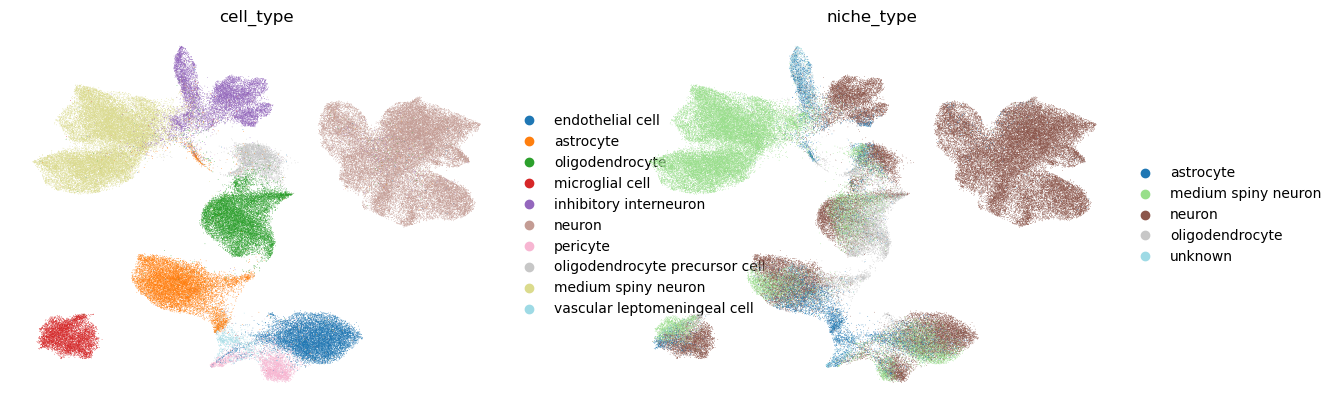

In [53]:
if plots:
    sc.pp.neighbors(adata, use_rep="so_r1_kl1_c20_n20" + "_X_nicheVI")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "niche_type"],
        ncols=3,
        frameon=False,
        palette="tab20",
    )

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_utils.py:430: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns[value_to_plot + '_colors'] = colors_list
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


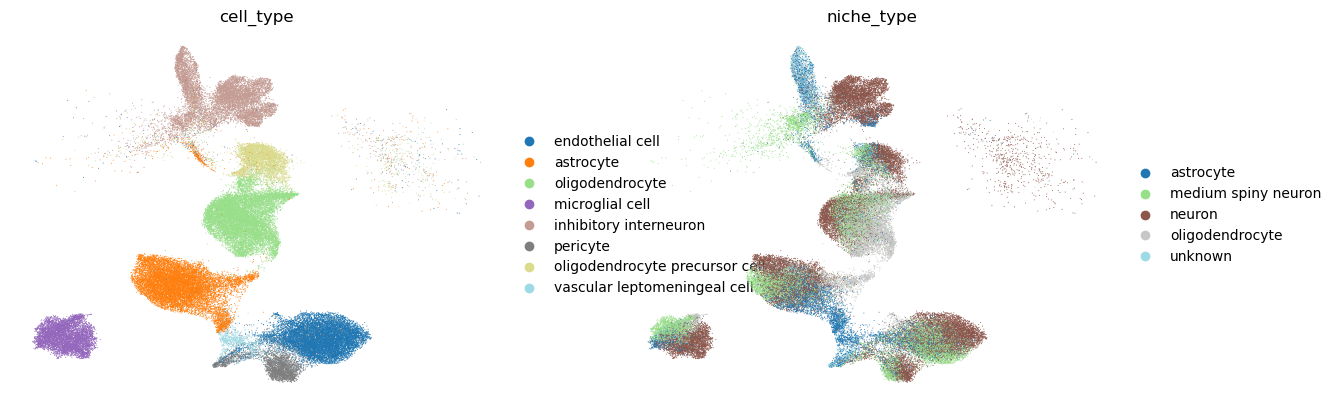

In [54]:
if plots:
    sc.pp.neighbors(adata, use_rep="so_r1_kl1_c20_n20_X_nicheVI")
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata[~adata.obs["cell_type"].isin(["neuron", "medium spiny neuron"])],
        color=["cell_type", "niche_type"],
        ncols=3,
        frameon=False,
        palette="tab20",
    )

## scib-metrics

In [173]:
adata.obsm["X_ldvae"] = adata.obsm["qz1_m"]
# adata.obsm["X_scVI"] = scvivae.get_latent_representation()

print(adata.obsm)

AxisArrays with keys: X_pca, X_spatial, X_umap, centroids, spatial, X_scVI, qz1_m, qz1_var, niche_indexes, 
niche_distances, neighborhood_composition, latent_mean_knn, qz1_m_niche_ct, qz1_var_niche_ct, 
so_r1_kl1_c10_n10_X_nicheVI, so_r1_kl1_c10_n10_pred_ct, so_r1_kl1_c10_n10_niche_act, z2, z1, 
Poisson_r1_kl1_c1_n1_X_nicheVI, Poisson_r1_kl1_c1_n1_pred_ct, Poisson_r1_kl1_c1_n1_niche_act, X_ldvae

Embeddings:  50%|█████     | 1/2 [02:51<02:51, 171.74s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 2/2 [05:33<00:00, 166.78s/it]


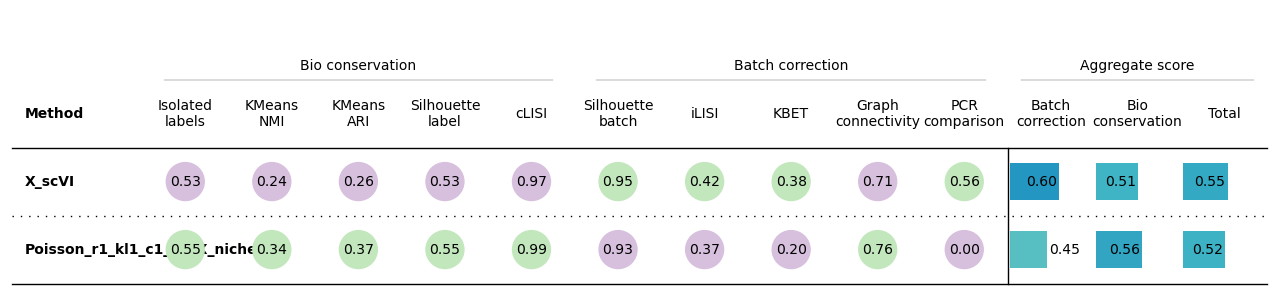

In [174]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="niche_type",
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [45]:
batchcorr = BatchCorrection(
    silhouette_batch=False,
    ilisi_knn=False,
    kbet_per_label=True,
    graph_connectivity=False,
    pcr_comparison=False,
)

Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 3/3 [00:12<00:00,  4.00s/it]


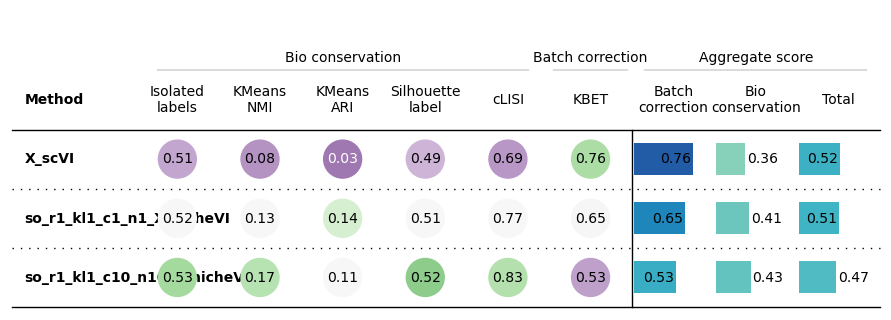

In [46]:
bm = Benchmarker(
    adata[adata.obs["cell_type"].isin(["oligodendrocyte precursor cell"])],
    batch_key="donor_slice",
    label_key="niche_type",
    batch_correction_metrics=batchcorr,
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

Computing neighbors:   0%|          | 0/3 [00:00<?, ?it/s]

Embeddings: 100%|██████████| 3/3 [00:22<00:00,  7.52s/it]


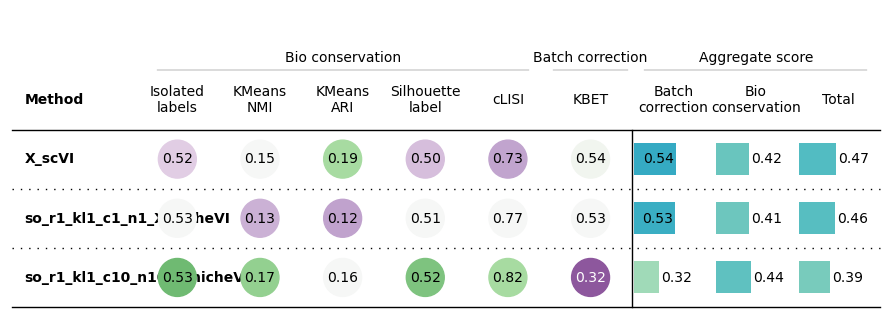

In [47]:
bm = Benchmarker(
    adata[adata.obs["cell_type"].isin(["astrocyte"])],
    batch_key="donor_slice",
    label_key="niche_type",
    batch_correction_metrics=batchcorr,
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

Computing neighbors:   0%|          | 0/2 [00:00<?, ?it/s]

Embeddings:  50%|█████     | 1/2 [04:37<04:37, 277.10s/it]/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scib_metrics/_pcr_comparison.py:49: UserWarning: PCR comparison score is negative, meaning variance contribution increased after integration. Setting to 0.
  warnings.warn(
Embeddings: 100%|██████████| 2/2 [09:16<00:00, 278.48s/it]


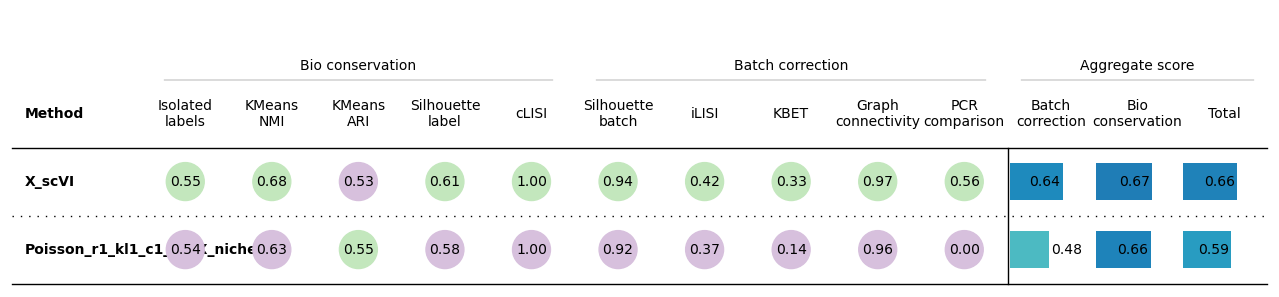

In [175]:
bm = Benchmarker(
    adata,
    batch_key="donor_slice",
    label_key="cell_type",
    embedding_obsm_keys=[
        # "X_pca",
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    n_jobs=-1,
)
bm.benchmark()
bm.plot_results_table(min_max_scale=False)

In [70]:
# df = bm.get_results(min_max_scale=False)
# print(df)

## spatial metrics

In [123]:
sa = SpatialAnalysis(
    adata=adata,
    label_key="cell_type",
    sample_key="donor_slice",
    latent_space_keys=[
        # "X_ldvae",
        "X_scVI",
    ]
    + latent_keys_for_benchmark,
    spatial_coord_key="centroids",
    ct_composition_key="neighborhood_composition",
    z1_reference="X_scVI",
    train_indices=nichevae.train_indices,
    validation_indices=nichevae.validation_indices,
    ###########
    set_of_metrics=["distance", "similarity"],
    similarity_metric="kl",
    reduction=["mean", "mean"],
)

In [124]:
latent_keys_for_benchmark

['Poisson_r1_kl1_c1_n1_X_nicheVI']

In [72]:
# sa.leiden_clusters(
#     resolution=0.5,
#     sample_subset=["Donor_8-slice_0", "Donor_1-slice_0", "Donor_7-slice_0"],
#     plot=False,
# )

In [146]:
sa.compute_metrics(
    k_nn_range=[25, 50, 100, 200],  # what is the optimal k_nn?
)

X_scVI:   0%|          | 0/10 [00:00<?, ?it/s]

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a non-main thread, the TBB library may be in an invalid state in the child process.
Numba: Attempted to fork from a 

In [135]:
comparison_key = "Poisson_r1_kl1_c1_n1_X_nicheVI"

In [74]:
# sa.cluster_stats["X_scVI"].mean

In [75]:
# sa.plot_metrics(metric="distance", plot_type="kde")
# sa.plot_metrics(metric="distance", plot_type="ecdf")

In [76]:
# sa.plot_metrics(metric="similarity", plot_type="kde")
# sa.plot_metrics(metric="similarity", plot_type="ecdf")

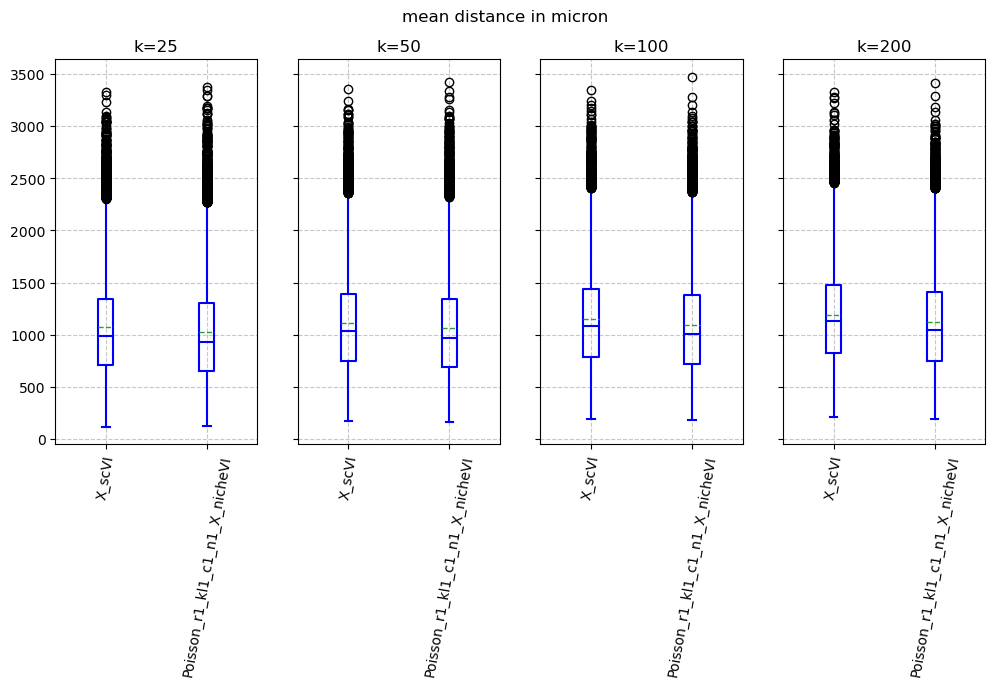

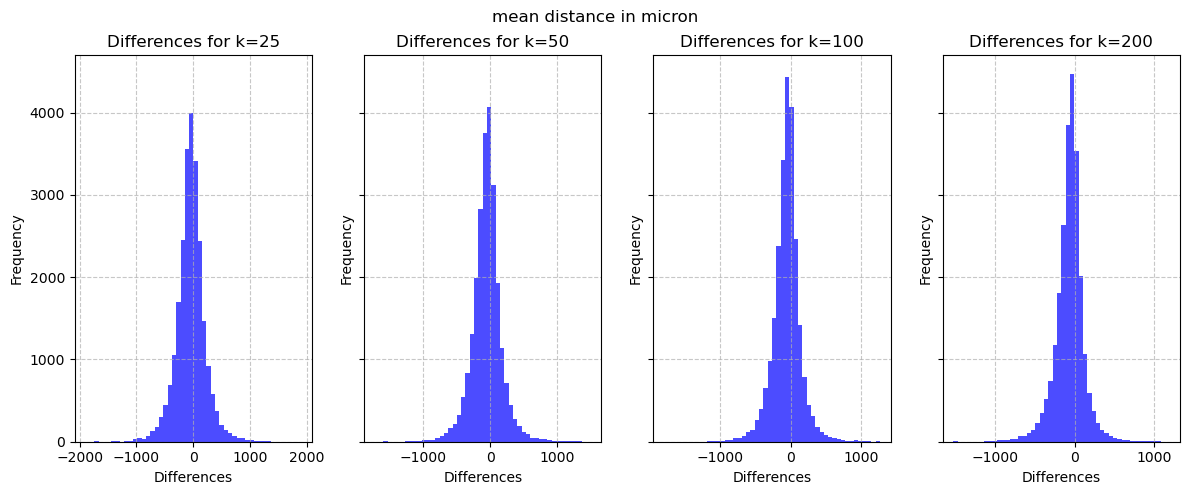

Positive differences:

k=25      k=50     k=100     k=200
cell_type                                                             
oligodendrocyte                 0.422323  0.391403  0.378582  0.356335
neuron                          0.449409  0.432257  0.395503  0.353704
endothelial cell                0.378578  0.348222  0.340850  0.339115
pericyte                        0.406977  0.389535  0.376453  0.329942
microglial cell                 0.377463  0.339638  0.329393  0.294720
medium spiny neuron             0.395882  0.363442  0.329837  0.291181
astrocyte                       0.374647  0.344368  0.315704  0.287848
oligodendrocyte precursor cell  0.348624  0.313073  0.308486  0.283257
inhibitory interneuron          0.425270  0.393805  0.349066  0.283186
vascular leptomeningeal cell    0.364055  0.313364  0.294931  0.221198

Negative differences:

k=25      k=50     k=100     k=200
cell_type                                                             
vascular leptomeningeal cell    0.635945  0.686636  0.705069  0.778802
inhibitory interneuron          0.574730  0.606195  0.650934  0.716814
oligodendrocyte precursor cell  0.651376  0.686927  0.691514  0.716743
astrocyte                       0.625353  0.655632  0.684296  0.712152
medium spiny neuron             0.604118  0.636558  0.670163  0.708819
microglial cell                 0.622537  0.660362  0.670607  0.705280
pericyte                        0.593023  0.610465  0.623547  0.670058
endothelial cell                0.621422  0.651778  0.659150  0.660885
neuron                          0.550591  0.567743  0.604497  0.646296
oligodendrocyte                 0.577677  0.608597  0.621418  0.643665

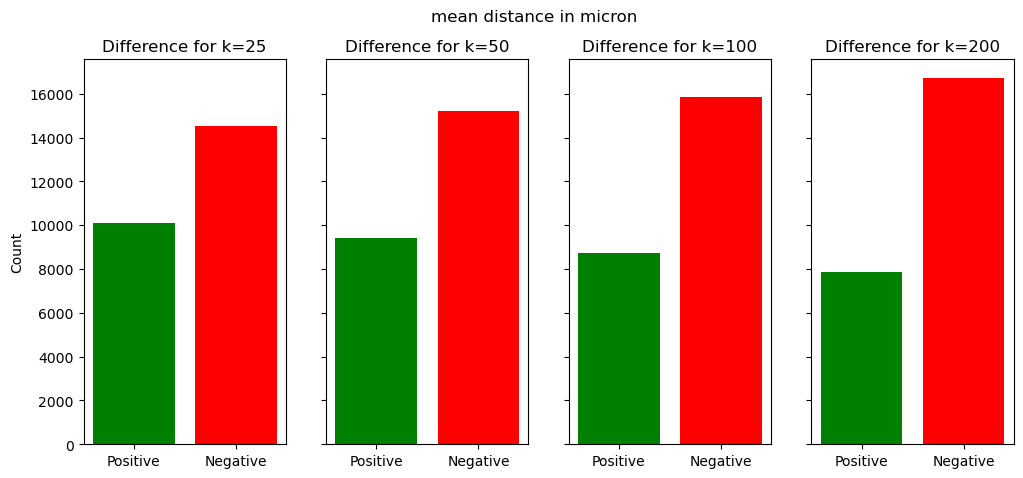

In [161]:
sa.boxplot_metrics(
    metric="distance",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="boxplot",
)

sa.boxplot_metrics(
    metric="distance",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="hist",
)

sa.boxplot_metrics(
    metric="distance",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="barplot",
)

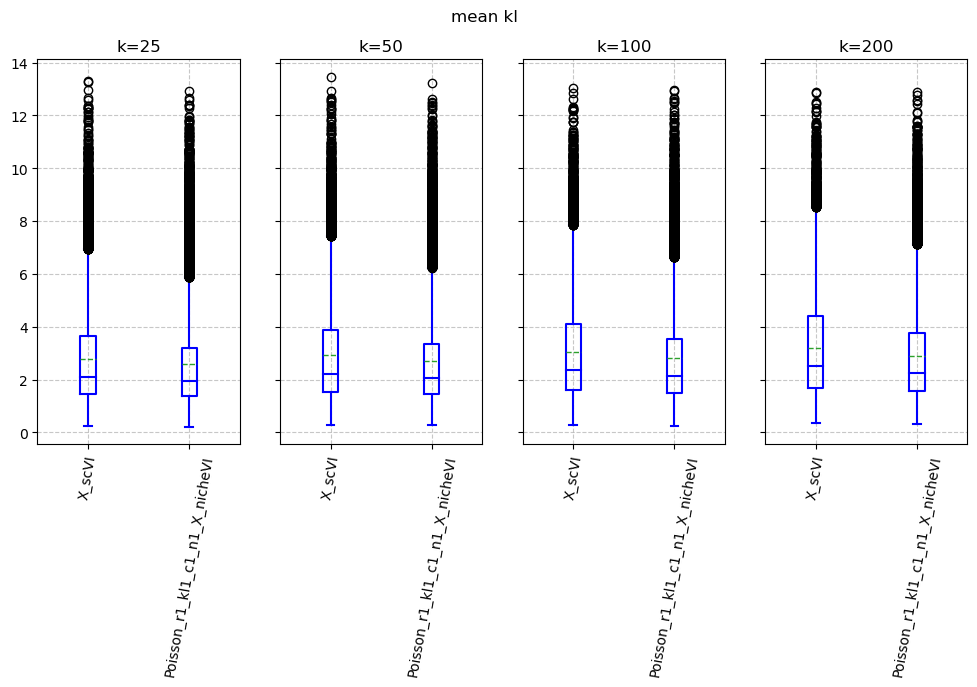

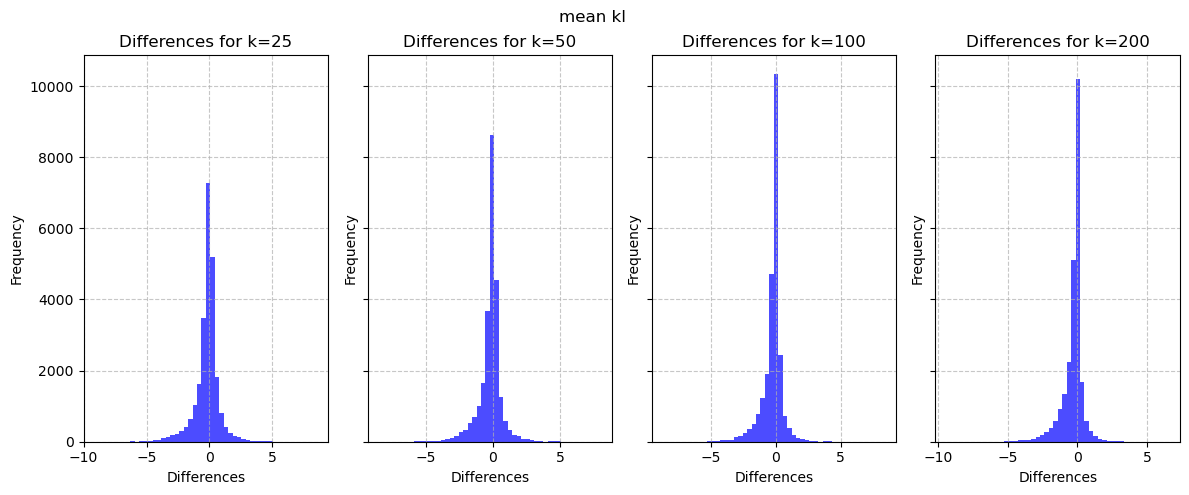

Positive differences:

k=25      k=50     k=100     k=200
cell_type                                                             
medium spiny neuron             0.465812  0.462510  0.436286  0.398019
neuron                          0.475353  0.454742  0.417844  0.355866
microglial cell                 0.406619  0.380615  0.354610  0.312845
endothelial cell                0.375976  0.356028  0.340850  0.311362
astrocyte                       0.377473  0.337101  0.301171  0.277755
oligodendrocyte                 0.387255  0.334087  0.310332  0.276395
pericyte                        0.372093  0.353198  0.325581  0.251453
inhibitory interneuron          0.440511  0.396264  0.327925  0.219764
oligodendrocyte precursor cell  0.324541  0.292431  0.237385  0.202982
vascular leptomeningeal cell    0.313364  0.235023  0.152074  0.165899

Negative differences:

k=25      k=50     k=100     k=200
cell_type                                                             
vascular leptomeningeal cell    0.686636  0.764977  0.847926  0.834101
oligodendrocyte precursor cell  0.675459  0.707569  0.762615  0.797018
inhibitory interneuron          0.559489  0.603736  0.672075  0.780236
pericyte                        0.627907  0.646802  0.674419  0.748547
oligodendrocyte                 0.612745  0.665913  0.689668  0.723605
astrocyte                       0.622527  0.662899  0.698829  0.722245
endothelial cell                0.624024  0.643972  0.659150  0.688638
microglial cell                 0.593381  0.619385  0.645390  0.687155
neuron                          0.524647  0.545258  0.582156  0.644134
medium spiny neuron             0.534188  0.537490  0.563714  0.601981

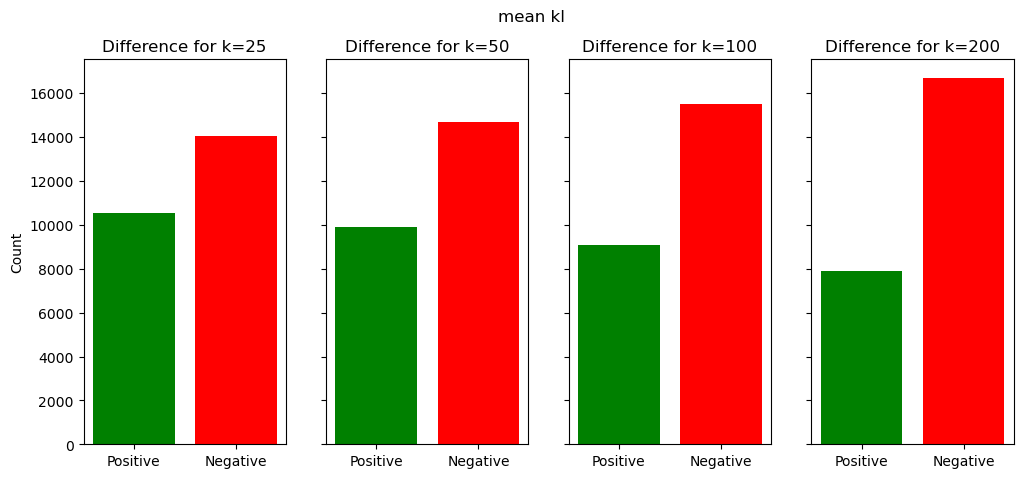

In [162]:
sa.boxplot_metrics(
    metric="similarity",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="boxplot",
)

sa.boxplot_metrics(
    metric="similarity",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="hist",
)

sa.boxplot_metrics(
    metric="similarity",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="barplot",
)

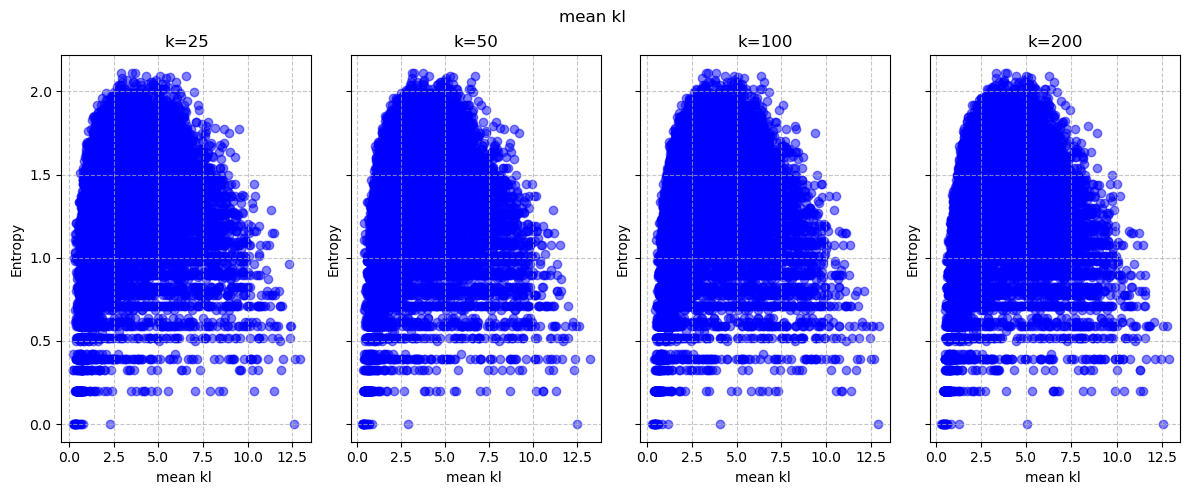

In [169]:
sa.boxplot_metrics(
    metric="similarity",
    reference_key="X_scVI",
    comparison_key=comparison_key,
    plot_type="entropy",
)

In [150]:
df_dist = sa.test_distributions(
    test="mannwhitneyu",
    distribution="distance",
    plot=None,
)
df_dist[200]

Mean distance train  Std distance train  \
Model                                                                     
Poisson_r1_kl1_c1_n1_X_nicheVI             1100.481             459.581   
X_scVI                                     1189.116             458.369   

                                p-value corrected train  \
Model                                                     
Poisson_r1_kl1_c1_n1_X_nicheVI                      0.0   
X_scVI                                              1.0   

                                Mean distance validation  \
Model                                                      
Poisson_r1_kl1_c1_n1_X_nicheVI                  1125.313   
X_scVI                                          1191.741   

                                Std distance validation  \
Model                                                     
Poisson_r1_kl1_c1_n1_X_nicheVI                  474.185   
X_scVI                                          461.868   

                                p-value corrected validation  
Model                                                         
Poisson_r1_kl1_c1_n1_X_nicheVI                           0.0  
X_scVI                                                   1.0

In [151]:
df_sim = sa.test_distributions(
    test="mannwhitneyu",
    distribution="similarity",
    plot=None,
)
df_sim[200]

Mean similarity train  Std similarity train  \
Model                                                                         
Poisson_r1_kl1_c1_n1_X_nicheVI                  2.809                 1.779   
X_scVI                                          3.211                 2.019   

                                p-value corrected train  \
Model                                                     
Poisson_r1_kl1_c1_n1_X_nicheVI                      0.0   
X_scVI                                              1.0   

                                Mean similarity validation  \
Model                                                        
Poisson_r1_kl1_c1_n1_X_nicheVI                       2.911   
X_scVI                                               3.211   

                                Std similarity validation  \
Model                                                       
Poisson_r1_kl1_c1_n1_X_nicheVI                      1.894   
X_scVI                                              2.004   

                                p-value corrected validation  
Model                                                         
Poisson_r1_kl1_c1_n1_X_nicheVI                           0.0  
X_scVI                                                   1.0

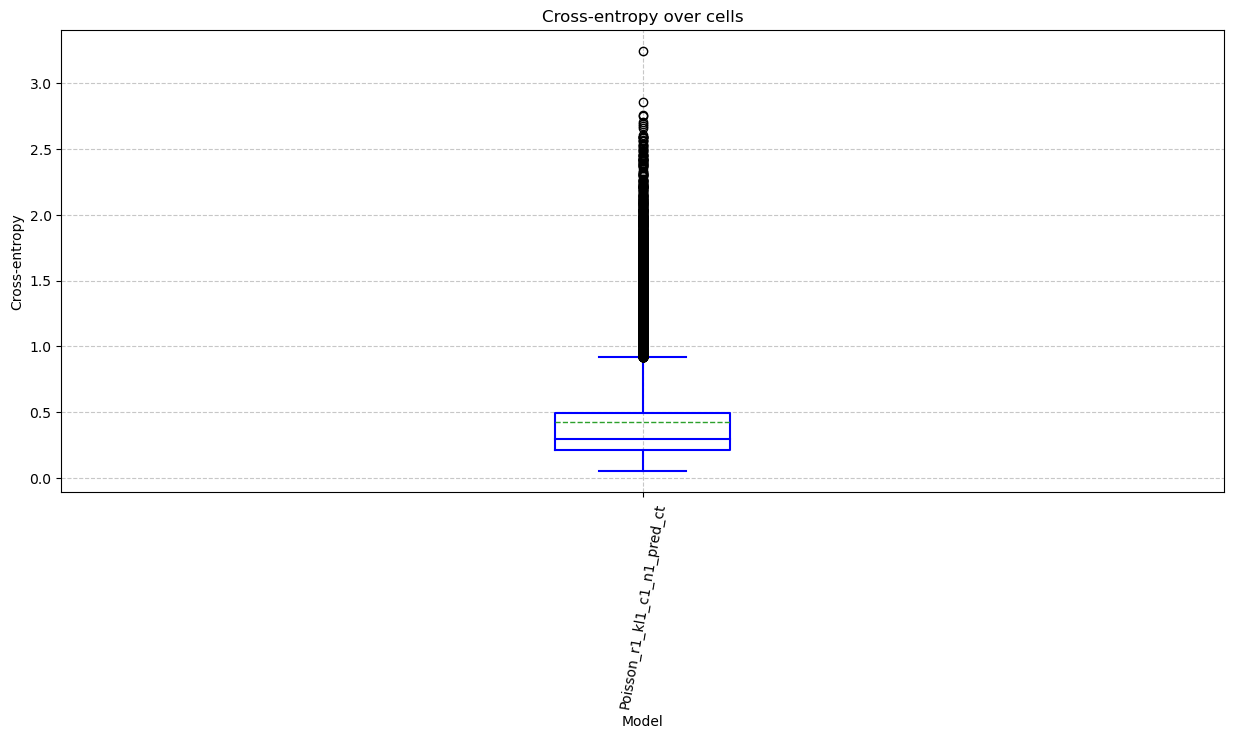

Model  validation CE 
0  Poisson_r1_kl1_c1_n1_pred_ct        0.429101

In [142]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    validation_only=True,
    metric="CE",
)

In [104]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    validation_only=True,
    metric="AUC",
)

Saved metric in: 
['val_auc_Poisson_r1_kl1_c1_n1_pred_ct']

validation AUC 
Model                                        
Poisson_r1_kl1_c1_n1_pred_ct            0.724

In [105]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    validation_only=True,
    metric="CE",
)

Saved metric in: 
['val_ce_so_r1_kl1_c10_n10_pred_ct']

validation CE 
Model                                    
so_r1_kl1_c10_n10_pred_ct           0.327

In [52]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    train_only=True,
    metric="Pearson",
)

Saved metric in: 
[
    'train_corr_so_r1_kl1_c10_n10_pred_ct',
    'train_corr_so_r1_kl1_c1_n1_pred_ct',
    'train_corr_so_r1_kl1_c1_n1_z20_pred_ct',
    'train_corr_so_r1_kl1_c10_n10_z20_pred_ct',
    'train_corr_so_r1_kl1_c20_n20_pred_ct'
]

train Pearson 
Model                                        
so_r1_kl1_c20_n20_pred_ct               0.476
so_r1_kl1_c10_n10_z20_pred_ct           0.469
so_r1_kl1_c10_n10_pred_ct               0.466
so_r1_kl1_c1_n1_pred_ct                 0.404
so_r1_kl1_c1_n1_z20_pred_ct             0.404

In [53]:
sa.compare_neighborhoods(
    comparison_keys=pred_keys_for_benchmark,
    train_only=True,
    metric="AUC",
)

Saved metric in: 
[
    'train_auc_so_r1_kl1_c10_n10_pred_ct',
    'train_auc_so_r1_kl1_c1_n1_pred_ct',
    'train_auc_so_r1_kl1_c1_n1_z20_pred_ct',
    'train_auc_so_r1_kl1_c10_n10_z20_pred_ct',
    'train_auc_so_r1_kl1_c20_n20_pred_ct'
]

train AUC 
Model                                    
so_r1_kl1_c10_n10_pred_ct           0.744
so_r1_kl1_c20_n20_pred_ct           0.744
so_r1_kl1_c10_n10_z20_pred_ct       0.742
so_r1_kl1_c1_n1_z20_pred_ct         0.726
so_r1_kl1_c1_n1_pred_ct             0.722

In [60]:
adata.uns["train_auc_so_r1_kl1_c10_n0_pred_ct"]

astrocyte  inhibitory interneuron  \
astrocyte                        0.718365                0.679399   
inhibitory interneuron           0.686829                0.724934   
microglial cell                  0.610381                0.637147   
oligodendrocyte                  0.621960                0.686305   
neuron                           0.571342                0.670898   
endothelial cell                 0.590355                0.581162   
medium spiny neuron              0.567754                0.577839   
oligodendrocyte precursor cell   0.618769                0.663054   
pericyte                         0.637073                0.623474   
vascular leptomeningeal cell     0.827679                0.619565   
weighted_mean                    0.610632                0.646442   

                                microglial cell  oligodendrocyte    neuron  \
astrocyte                              0.527099         0.692183  0.885655   
inhibitory interneuron                 0.518494         0.665292  0.947265   
microglial cell                        0.498983         0.637459  0.939911   
oligodendrocyte                        0.542078         0.762389  0.852083   
neuron                                 0.574958         0.787025  0.973645   
endothelial cell                       0.500331         0.596164  0.897688   
medium spiny neuron                    0.555160         0.671497  0.658269   
oligodendrocyte precursor cell         0.523638         0.696476  0.923506   
pericyte                               0.511000         0.657226  0.885059   
vascular leptomeningeal cell           0.530651         0.739442  0.754147   
weighted_mean                          0.542817         0.707651  0.868487   

                                endothelial cell  medium spiny neuron  \
astrocyte                               0.582056             0.874781   
inhibitory interneuron                  0.529854             0.889344   
microglial cell                         0.534345             0.923206   
oligodendrocyte                         0.595937             0.802207   
neuron                                  0.623946             0.663941   
endothelial cell                        0.534216             0.892231   
medium spiny neuron                     0.552124             0.992477   
oligodendrocyte precursor cell          0.569533             0.886014   
pericyte                                0.545818             0.888208   
vascular leptomeningeal cell            0.601870             0.791962   
weighted_mean                           0.576537             0.837696   

                                oligodendrocyte precursor cell  pericyte  \
astrocyte                                             0.541227  0.567065   
inhibitory interneuron                                0.532879  0.517360   
microglial cell                                       0.538216  0.520450   
oligodendrocyte                                       0.552511  0.525226   
neuron                                                0.548132  0.524600   
endothelial cell                                      0.509584  0.552323   
medium spiny neuron                                   0.527549  0.526399   
oligodendrocyte precursor cell                        0.581179  0.529420   
pericyte                                              0.533134  0.679668   
vascular leptomeningeal cell                          0.527841  0.637249   
weighted_mean                                         0.538759  0.536763   

                                vascular leptomeningeal cell  weighted_mean  
astrocyte                                           0.755262       0.759515  
inhibitory interneuron                              0.605325       0.769193  
microglial cell                                     0.648311       0.755960  
oligodendrocyte                                     0.528331       0.732118  
neuron                                              0.562947       0.737897  
endothel

In [ ]:
adata.uns["val_corr_s_r01_kl1_c1_n10_pred_ct"]

astrocyte  inhibitory interneuron  \
astrocyte                        0.500174                0.368843   
inhibitory interneuron           0.358445                0.704918   
microglial cell                  0.263001                0.210812   
oligodendrocyte                  0.216606                0.307747   
neuron                           0.219131                0.288166   
endothelial cell                 0.253640                0.151738   
medium spiny neuron              0.232038                0.443478   
oligodendrocyte precursor cell   0.294617                0.322422   
pericyte                         0.283238                0.222232   
vascular leptomeningeal cell     0.492509                0.394543   
weighted_mean                    0.273753                0.348888   

                                microglial cell  oligodendrocyte    neuron  \
astrocyte                              0.073614         0.703790  0.672611   
inhibitory interneuron                 0.000696         0.339314  0.738869   
microglial cell                        0.042789         0.478092  0.645650   
oligodendrocyte                        0.074091         0.577350  0.618295   
neuron                                 0.127048         0.520855  0.305051   
endothelial cell                       0.000706         0.413948  0.567324   
medium spiny neuron                    0.051167         0.266182  0.728525   
oligodendrocyte precursor cell         0.050809         0.655588  0.659942   
pericyte                               0.097489         0.471543  0.555749   
vascular leptomeningeal cell           0.107833         0.511395  0.531600   
weighted_mean                          0.069746         0.468148  0.564054   

                                endothelial cell  medium spiny neuron  \
astrocyte                               0.217406             0.619383   
inhibitory interneuron                  0.136991             0.757954   
microglial cell                         0.068334             0.579831   
oligodendrocyte                         0.174475             0.460708   
neuron                                  0.245947             0.516827   
endothelial cell                        0.105273             0.522011   
medium spiny neuron                     0.017109             0.358095   
oligodendrocyte precursor cell          0.158298             0.590190   
pericyte                                0.123354             0.530779   
vascular leptomeningeal cell            0.251125             0.462858   
weighted_mean                           0.149636             0.514074   

                                oligodendrocyte precursor cell  pericyte  \
astrocyte                                             0.068514  0.309346   
inhibitory interneuron                                0.044564  0.052509   
microglial cell                                       0.053749  0.064719   
oligodendrocyte                                       0.111076  0.073215   
neuron                                                0.077088  0.047277   
endothelial cell                                      0.013725  0.415144   
medium spiny neuron                                   0.063855  0.014151   
oligodendrocyte precursor cell                        0.203468  0.114528   
pericyte                                              0.075293  0.738599   
vascular leptomeningeal cell                         -0.009922  0.482691   
weighted_mean                                         0.070949  0.130901   

                                vascular leptomeningeal cell  weighted_mean  
astrocyte                                           0.566704       0.516283  
inhibitory interneuron                              0.097455       0.514722  
microglial cell                                     0.189081       0.412867  
oligodendrocyte                                     0.028275       0.406683  
neuron                                              0.086478       0.330644  
endothel

## EXPERIMENTAL

/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/nathanlevy/mambaforge/envs/phenospace_23/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


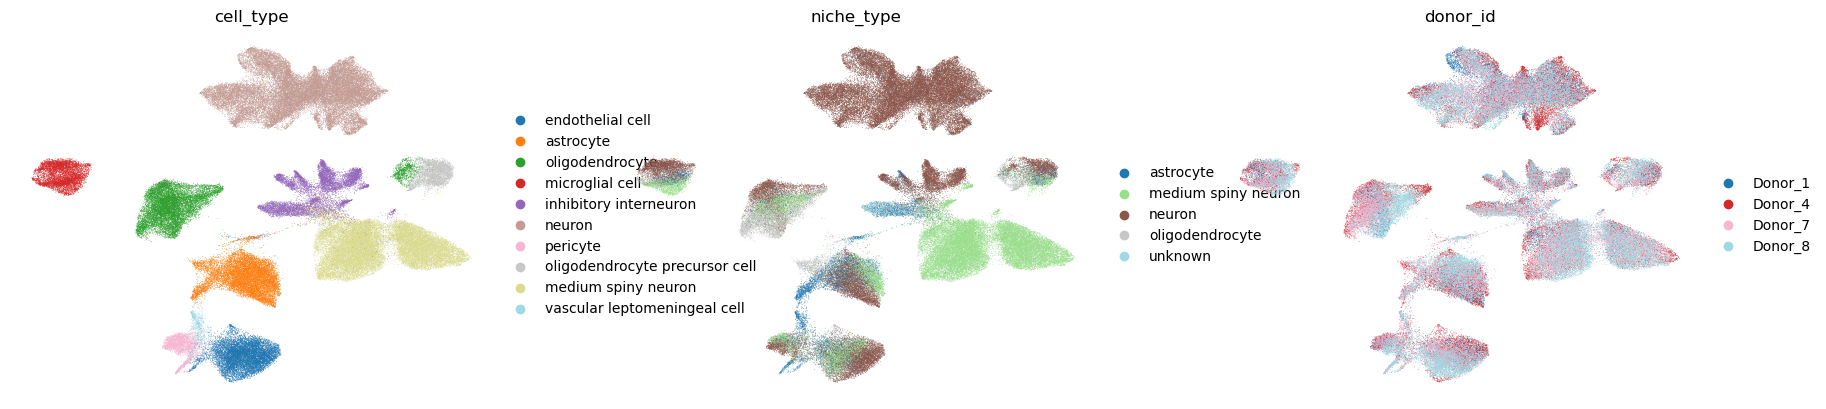

In [87]:
exp_key = "so_r1_kl1_c10_n10_X_nicheVI"

if plots:
    sc.pp.neighbors(adata, use_rep=exp_key)
    sc.tl.umap(adata, min_dist=0.3)

    sc.pl.umap(
        adata,
        color=["cell_type", "niche_type", "donor_id"],
        ncols=3,
        frameon=False,
        # palette="tab20",
    )

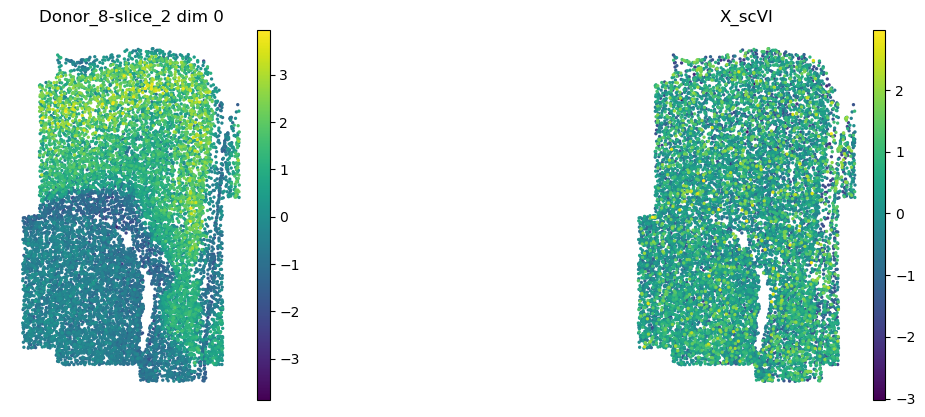

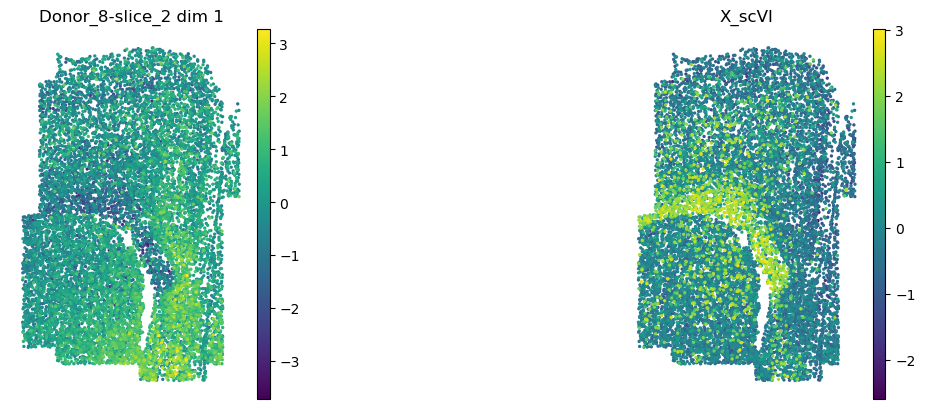

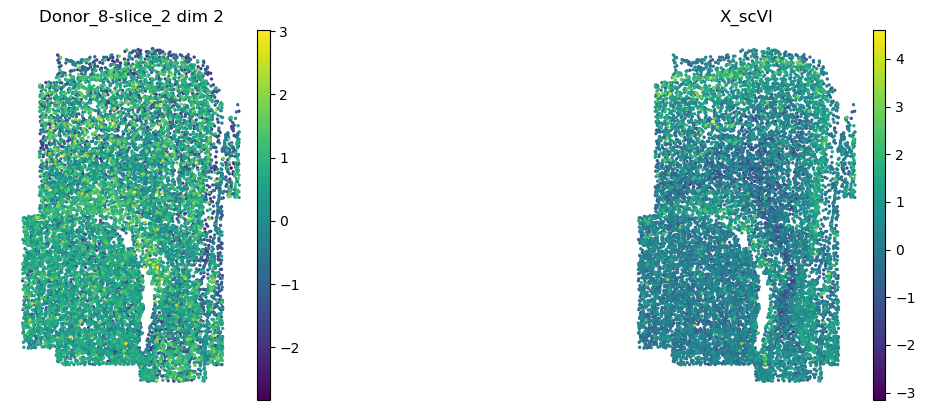

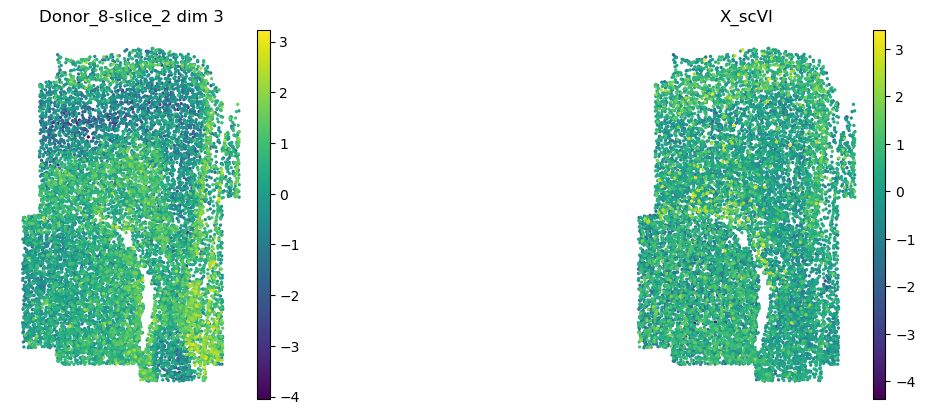

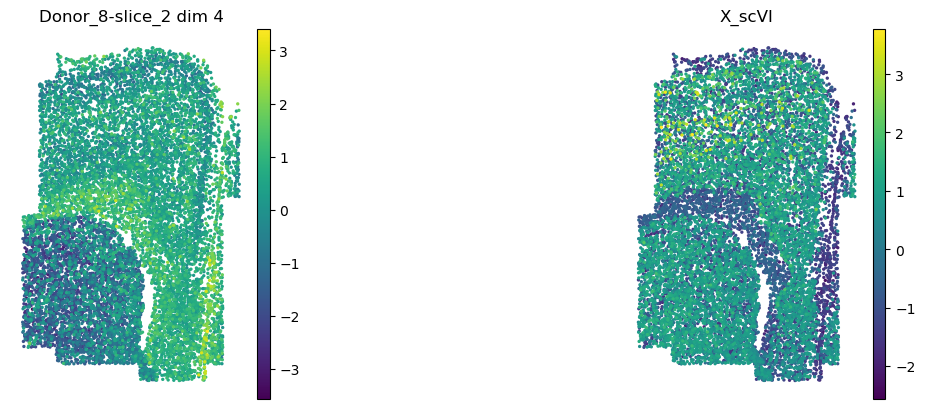

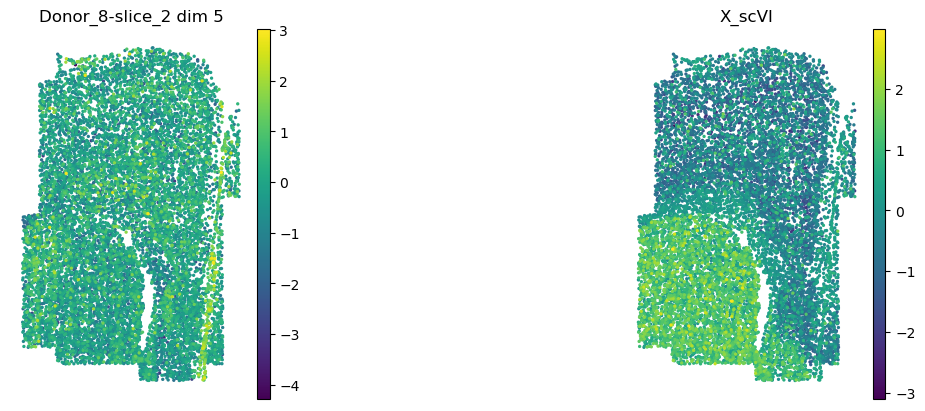

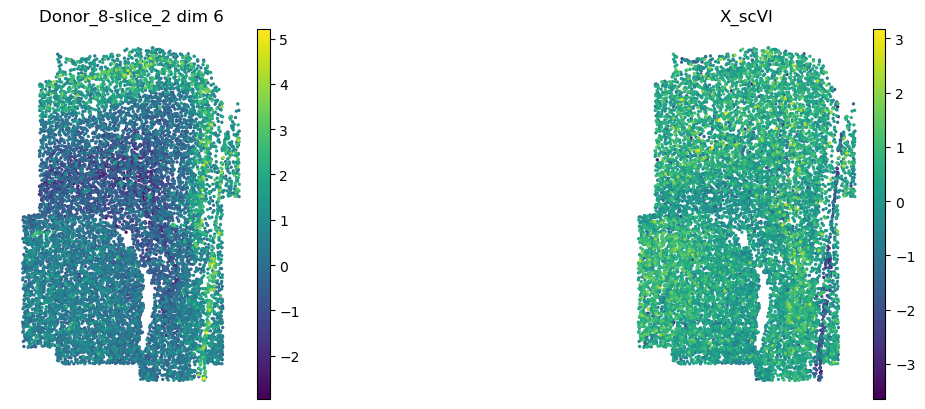

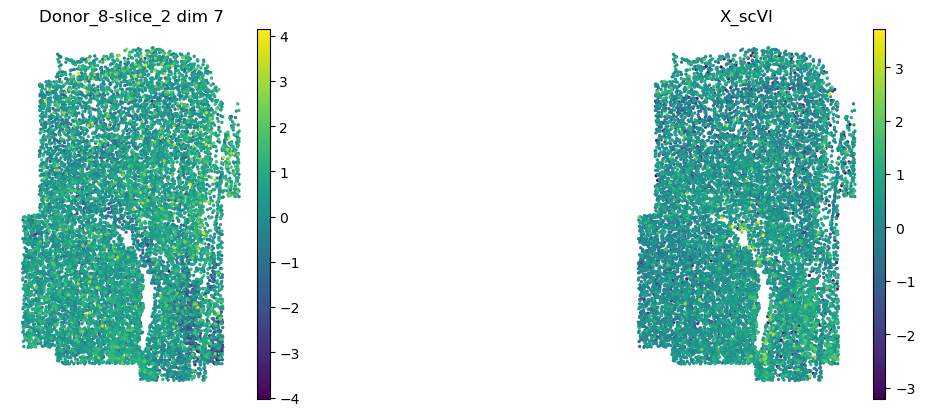

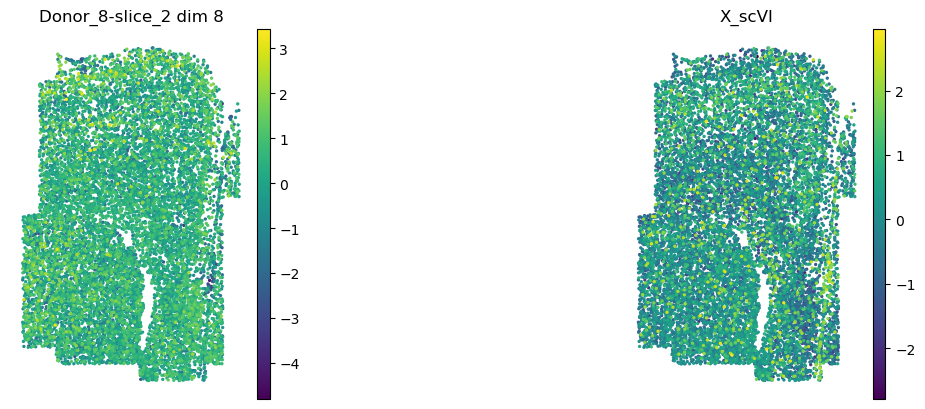

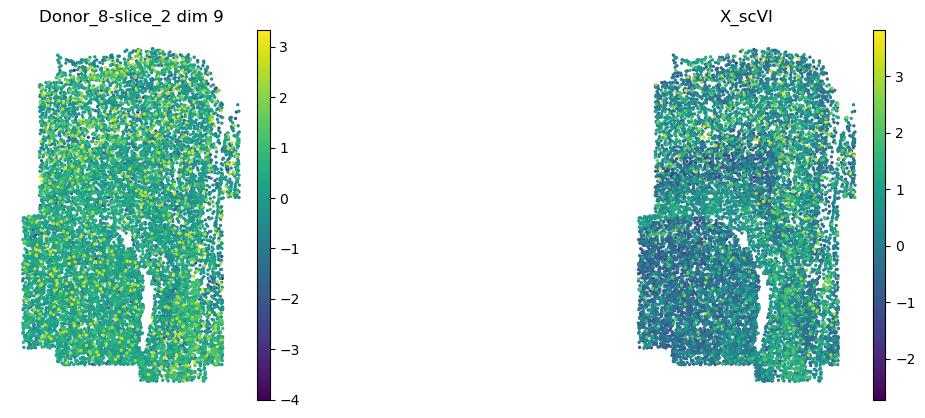

In [84]:
# for sample in adata.obs.donor_slice.unique().tolist()[:1]:
for sample in ["Donor_8-slice_2"]:
    adata_sample = adata[adata.obs["donor_slice"] == sample].copy()

    for dim in range(10):
        # adata_sample.obs["z1_neuron"] = adata_sample.obsm["qz1_m_niche_ct"][:, 3, dim]
        adata_sample.obs["X_nicheVI"] = adata_sample.obsm[exp_key][:, dim]
        adata_sample.obs["X_scVI"] = adata_sample.obsm["X_scVI"][:, dim]
        sc.pl.spatial(
            adata=adata_sample,
            spot_size=40,
            color=["X_nicheVI", "X_scVI"],
            ncols=2,
            frameon=False,
            title=sample + " dim " + str(dim),
            palette="magma",
        )

CELL TYPES IN SPACE

In [1]:
# # for sample in adata.obs.donor_slice.unique().tolist()[:3]:
# for sample in ["Donor_8-slice_2"]:
#     adata_sample = adata[adata.obs["donor_slice"] == sample].copy()
#     for type in [
#         "endothelial cell",
#         "microglial cell",
#         "pericyte",
#         "oligodendrocyte",
#         "inhibitory interneuron",
#         "astrocyte",
#         "medium spiny neuron",
#         "neuron",
#         "oligodendrocyte precursor cell",
#         "vascular leptomeningeal cell",
#     ]:
#         sc.pl.spatial(
#             adata=adata_sample[adata_sample.obs["cell_type"].isin([type])],
#             spot_size=40,
#             color=["cell_type"],
#             ncols=1,
#             frameon=False,
#             title=sample,
#             palette="tab20",
#         )